**[Нажмите сюда, чтобы посмотреть результат на kaggle.](https://www.kaggle.com/competitions/startups-operations-close-predictions-m-1-39-ds/leaderboard)**  

In [1]:
#! pip install numpy==1.22.4 -q
#! pip install phik==0.12.4 -q
#! pip install shap==0.44.0 -q
#! pip install scikit-learn==1.5.0 -q
#!pip install catboost
#import math
import datetime
import  pandas as pd 
import  numpy as np
import  matplotlib.pyplot as plt
import  seaborn as sns


from  sklearn.model_selection import   (train_test_split,
                                        GridSearchCV,
                                        RandomizedSearchCV)

from  sklearn.metrics         import    (f1_score, 
                                         classification_report)

from catboost import (CatBoostClassifier,
                     Pool)
from scipy.stats import (randint,
                         uniform)
from phik import phik_matrix
import shap
import warnings
warnings.filterwarnings("ignore") # игнорирование предупреждений

pd.set_option('display.max_colwidth', None) #для полного отображения строки в датафрейме
pd.set_option('display.max_columns',  None) # для отображения макс.количества столбцов
RANDOM_STATE = 42 # переменная для фиксирования случайности


*Примечание: работа выполнена в JupyterLab со встроенным toc, которая входит в виртуальное окружение для всех проектов Яндекс-Практикума. Слева в нем есть вкладка Table of Content. В ней автоматически формируется структура документа в зависимости от Markdown-заголовков.*

# Моделирование продолжения деятельности стартапа

## Описание данных и цели проекта

**Требования заказчика:**     
Разработать модель машинного обучения для предсказания продолжения деятельности стартапа.         


Данные для работы находятся в двух таблицах.     
**kaggle_startups_train_28062024.csv**         
Таблица, которая содержит размеченные данные о стартапах.    

* name — наименование компании.
* category_list — список категорий деятельности.
* funding_total_usd — сумма привлеченных инвестиций в долларах.
* status — статус компании: действует стартап либо закрыт.
* country_code — код страны.
* state_code — код штата.
* region — регион.
* city — город.
* funding_rounds — число раундов, в которых компания привлекала инвестиции.
* founded_at — дата основания компании.
* first_funding_at — дата первого раунда.
* last_funding_at — дата последнего раунда.
* closed_at — дата закрытия компании, которую указывают в том случае, если компании больше не существует.            

**kaggle_startups_test_28062024.csv**         
Данные, по которым надо сделать прогноз о статусе стартапа. Не содержит столбцы: status, founded_at, closed_at. Однако есть информация о сроке жизни стартапа в днях (lifetime).               

В файле **kaggle_startups_sample_submit_28062024.csv** содержится образец ответа.

**Основные этапы работы:**   
1. Знакомство с данными и их предобработка.   
2. Исследовательский анализ данных.
3. Разработка новых признаков.
4. Корреляционный анализ данных.
5. Отбор признаков.
6. Моделирование продолжения деятельности стартапа.
7. Итоговая оценка качества предсказания лучшей модели.
8. Итоговый вывод по исследованию.  

## Знакомство с данными

### Считывание данных из файлов

**Считываем данные из csv-файлов в датафреймы и сохраним в переменные startups, kaggle_test.   
Пути к файлам: сказали прописать свой домашний путь (у ревьюера есть все 3 файла)**    

**Запишем функцию для считывания файлов. Она нам потребуется далее в работе (будет использоваться повторно)**.

In [2]:
def func_read():
    # считываем csv-файлы
    startups = pd.read_csv('kaggle_startups_train_28062024.csv')
    kaggle_test = pd.read_csv('kaggle_startups_test_28062024.csv')
    return startups, kaggle_test

In [3]:
startups, kaggle_test = func_read()

### Общая информация

#### Датафрейм "startups"

**Выведем случайные 5 строчек датафрейма `startups` и общую информацию о нем.**

In [4]:
startups.sample(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
41103,SMARTInsight Corporation,Big Data|Business Intelligence|Data Integration|Enterprise Software|SaaS,4099999.0,operating,JPN,40,NaN,NaN,1,2013-10-04,2015-07-27,2015-07-27,NaN
34352,Cartera Commerce,Advertising|Banking|Credit Cards|Discounts|Incentives|Shopping,38800000.0,operating,USA,MA,Boston,Lexington,9,2005-01-01,2005-08-01,2012-03-01,NaN
3121,L8 SmartLight,Gadget|Hardware + Software|Internet of Things|Sensors,203000.0,operating,USA,CA,San Diego,San Diego,1,2012-01-02,2012-08-01,2012-08-01,NaN
20948,DiaDerma BV,Health Care|Hospitals|Medical,19299.0,operating,NaN,NaN,NaN,NaN,1,2012-02-05,2013-11-11,2013-11-11,NaN
42413,GSI Health,Health Care,NaN,operating,USA,PA,Philadelphia,Philadelphia,1,2008-01-01,2015-06-16,2015-06-16,NaN


In [5]:
startups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [6]:
def percent_missing(data):
    """Функция возвращает процент пропущенных значений по столбцам
    Входные данные - датафрейм
    """
    result = 100*data.isna().mean()
    # выводить только колонки с пропусками (result > 0)
    result = result[result > 0].round(2)
    print(f'{result.shape[0]} столбцов имеют пропущенные значения')
    print(f'Процент пропущенных значений по столбцам')
    return result.sort_values()

In [7]:
percent_nan = percent_missing(startups)
percent_nan

8 столбцов имеют пропущенные значения
Процент пропущенных значений по столбцам


name                  0.00
category_list         4.69
country_code         10.48
region               12.11
city                 12.11
state_code           12.88
funding_total_usd    19.17
closed_at            90.64
dtype: float64

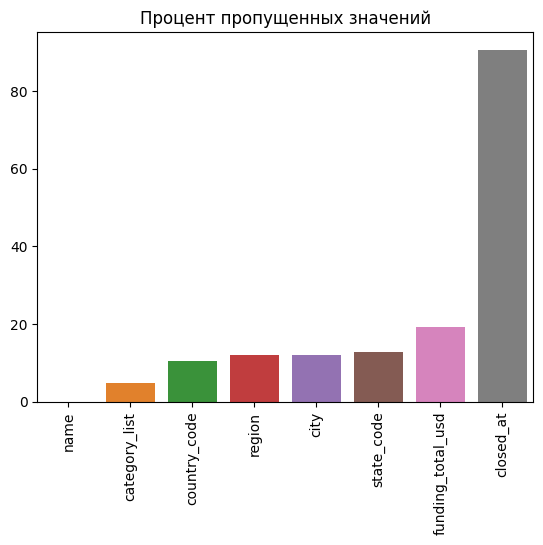

In [8]:
sns.barplot(x=percent_nan.index, y=percent_nan)
plt.xticks(rotation=90);
plt.title('Процент пропущенных значений');

**Вывод:**   
* В таблице startups содержится 52516 строк, 13 столбцов. Названия столбцов соответствуют змеиному стилю.
* В 8 столбцах есть пропущенные значения.
* Для категориальных столбцов (name, category_list, country_code, state_code, region, city) ввиду невозможности восстановления данных будем использовать заглушку.
* Для числового столбца funding_total_usd (сумма привлеченных инвестиций) будет заполнение некоторым значением, чем конкретно будет выбрано при исследовании данных.
* Столбцы founded_at, first_funding_at, last_funding_at, closed_at приведем к формату с датой.
* Столбец cloased_at содержит пропуски только для действующих стартапов, поэтому данные можно восстановить, заполнив датой выгрузки данных (последняя дата по столбцу).   
* Вес датафрейма 5.2+ Мб.

#### Датафрейм "kaggle_test"

**Выведем первые 5 строчек датафрейма `kaggle_test` и общую информацию о нем.**

In [9]:
kaggle_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [10]:
kaggle_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [11]:
percent_nan = percent_missing(kaggle_test)
percent_nan

6 столбцов имеют пропущенные значения
Процент пропущенных значений по столбцам


category_list         4.50
country_code         10.53
city                 12.09
region               12.11
state_code           12.91
funding_total_usd    19.64
dtype: float64

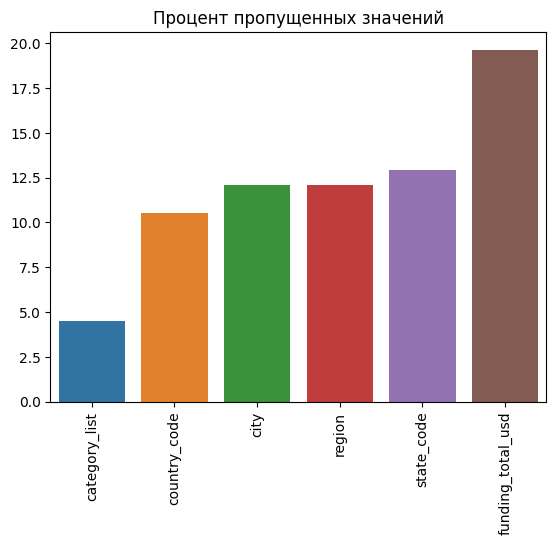

In [12]:
sns.barplot(x=percent_nan.index, y=percent_nan)
plt.xticks(rotation=90);
plt.title('Процент пропущенных значений');

**Вывод:**   
* В таблице kaggle_test содержится  13125 строк, 11 столбцов.  Названия столбцов соответствуют змеиному стилю.
* В 6 столбцах есть пропущенные значения.
* Для категориальных столбцов (category_list, country_code, state_code, region, city) ввиду невозможности восстановления данных будем использовать заглушку, такую же, как для данных таблицы startups.
* Для числового столбца funding_total_usd (сумма привлеченных инвестиций) будет заполнение некоторым значением, по аналогии с таблицей startups.
* Столбцы founded_at, first_funding_at, last_funding_at, closed_at приведем к формату с датой.
* Столбцы founded_at, closed_at отсутствуют в датафрейме kggle_test. Вместо них присутствует столбец lifetime (срок жизни проекта в днях).
* Отсутствует столбец status, так как это тестовый финальный датасет.   
* Вес датафрейма 1.1+ Мб.

Датафреймы должны содержать одинаковые столбцы при моделировании, поэтому для датафрейма **startups** необходимо создать столбец **lifetime**.

**Обратим внимание, что относительное количество пропусков примерно одинаково в обоих датасетах. Поэтому их заполнение надеемся сильно не исказит данные.**

#### Первоначальное сравнение структуры данных в датасетах startups и kaggle_test

In [13]:
startups.describe()

,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


In [14]:
kaggle_test.describe()

,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000


**Посмотрим на распределение данных в числовых колонках.**

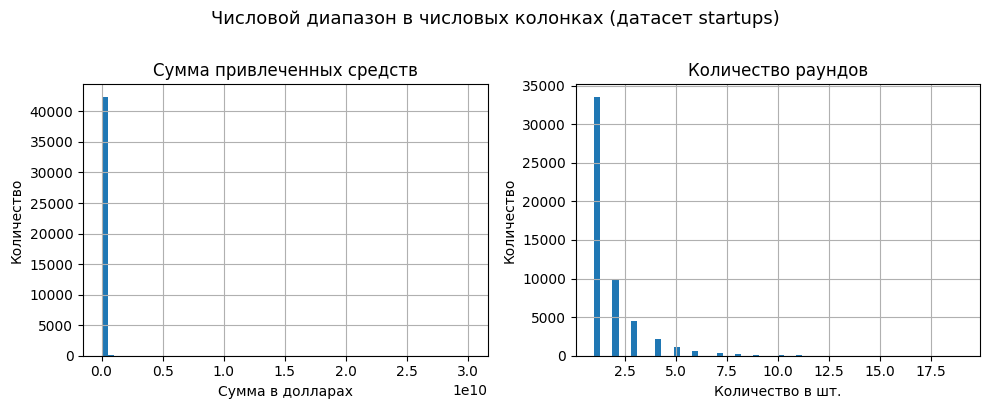

In [15]:
axes = startups.hist(figsize=(10,4), bins=60);
# Общий заголовок для всех колонок
plt.suptitle('Числовой диапазон в числовых колонках (датасет startups)', fontsize=13, y=1.01);
# списки для заголовков и подписей осей
titles = ['Сумма привлеченных средств','Количество раундов']
xlabel = ['Сумма в долларах','Количество в шт.']
ylabel = ['Количество']*2
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i]);
    ax.set_xlabel(xlabel[i]);
    ax.set_ylabel(ylabel[i]);

# чтобы оси не пересекались с соседними графиками
plt.tight_layout();

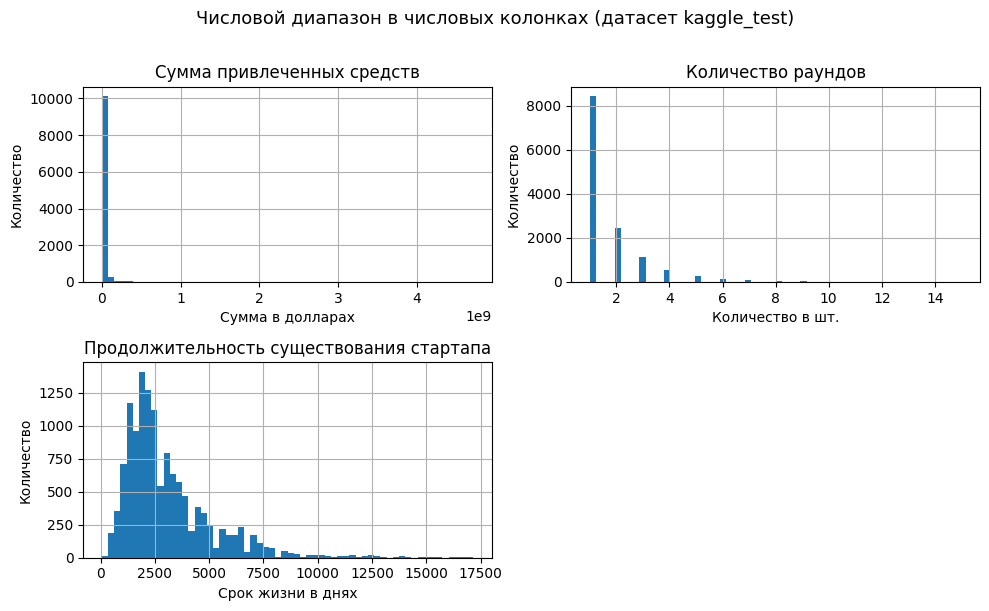

In [16]:
axes = kaggle_test.hist(figsize=(10,6), bins=60);
# Общий заголовок для всех колонок
plt.suptitle('Числовой диапазон в числовых колонках (датасет kaggle_test)', fontsize=13, y=1.01);
# списки для заголовков и подписей осей
titles = ['Сумма привлеченных средств','Количество раундов', 'Продолжительность существования стартапа', '']
xlabel = ['Сумма в долларах','Количество в шт.', 'Срок жизни в днях', '']
ylabel = ['Количество']*4
for i, ax in enumerate(axes.flat):
    ax.set_title(titles[i]);
    ax.set_xlabel(xlabel[i]);
    ax.set_ylabel(ylabel[i]);

# чтобы оси не пересекались с соседними графиками
plt.tight_layout();

Видим, что описательная статистика для датасетов по сумме привлеченных средств и количеству раундов не сильно отличается, за исключением показателей стандартного отклонения суммы привлеченных средств и максимальной суммы привлеченных средств. Так как медиана привлеченных средств одинакова для обоих датасетов, то можно сказать, что  такое отличие в стандартных отклонениях связано с выбросами в данных Об этом свидетельствует максимальная сумма привлеченных средств: в датасете startups она значительно выше.

**Необходимо учитывать это при построении моделей. Так как это обстоятельство может повлиять на их эффективность.**

## Предобработка данных

### Заполнение пропусков в категориальных колонках

#### Датасет startups

In [17]:
percent_missing(startups)

8 столбцов имеют пропущенные значения
Процент пропущенных значений по столбцам


name                  0.00
category_list         4.69
country_code         10.48
region               12.11
city                 12.11
state_code           12.88
funding_total_usd    19.17
closed_at            90.64
dtype: float64

**Заполним пропуски в категориальных колонках в датасете `startups`.**

Для категориальных столбцов (name, category_list, country_code, state_code, region, city) ввиду невозможности восстановления данных будем использовать заглушку "None".

In [18]:
startups[['name', 'category_list', 'country_code', 'region', 'city', 'state_code']] = \
startups[['name','category_list', 'country_code', 'region', 'city', 'state_code']].fillna('Unknown')

In [19]:
startups[['name','category_list', 'country_code', 'region', 'city', 'state_code']].isna().sum()

name             0
category_list    0
country_code     0
region           0
city             0
state_code       0
dtype: int64

**Заполним пропуски в колонке `closed_at`. Вместо NaN укажем дату выгрузки '2018-01-01'. Изменение типа данных выполним позже.**

In [20]:
startups['closed_at'] = startups['closed_at'].fillna('2018-01-01')

In [21]:
startups['closed_at'].fillna('2018-01-01').dtype

dtype('O')

#### Датасет kaggle_test

**Заполним пропуски в категориальных колонках в датасете `kaggle_test`.**

In [22]:
percent_missing(kaggle_test)

6 столбцов имеют пропущенные значения
Процент пропущенных значений по столбцам


category_list         4.50
country_code         10.53
city                 12.09
region               12.11
state_code           12.91
funding_total_usd    19.64
dtype: float64

In [23]:
kaggle_test[['category_list', 'country_code', 'region', 'city', 'state_code']] = \
kaggle_test[['category_list', 'country_code', 'region', 'city', 'state_code']].fillna('Unknown')

In [24]:
kaggle_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       13125 non-null  object 
 4   state_code         13125 non-null  object 
 5   region             13125 non-null  object 
 6   city               13125 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


### Изменение типа данных для колонок с датами

#### Датасет startups

In [25]:
startups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52516 non-null  object 
 1   category_list      52516 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       52516 non-null  object 
 5   state_code         52516 non-null  object 
 6   region             52516 non-null  object 
 7   city               52516 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          52516 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


**Измененим тип данных в столбцах `founded_at`, `first_funding_at`, `last_funding_at`, `closed_at`.**
Посмотрим на формат даты в столбцах.

In [26]:
startups[['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']].sample(5)

,founded_at,first_funding_at,last_funding_at,closed_at
35516,1992-01-01,2005-12-19,2005-12-19,2018-01-01
12646,2013-01-01,2013-03-22,2013-03-22,2018-01-01
13633,2004-01-01,2005-05-16,2005-05-16,2018-01-01
40046,2010-05-14,2012-12-26,2012-12-26,2018-01-01
42292,2015-02-20,2015-06-01,2015-06-01,2018-01-01


In [27]:
# преобразование в формат datetime
startups['founded_at'] = pd.to_datetime(startups['founded_at'], format='%Y-%m-%d')
startups['first_funding_at'] = pd.to_datetime(startups['first_funding_at'], format='%Y-%m-%d')
startups['last_funding_at'] = pd.to_datetime(startups['last_funding_at'], format='%Y-%m-%d')
startups['closed_at'] = pd.to_datetime(startups['closed_at'], format='%Y-%m-%d')

In [28]:
startups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          52516 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

Колонки `founded_at`, `first_funding_at`, `last_funding_at`, `closed_at` преобразованы к формату `datetime`.

#### Датасет kaggle_test

**Аналогичные изменения произведем для датасета kaggle_test.**

In [29]:
kaggle_test['first_funding_at'] = pd.to_datetime(kaggle_test['first_funding_at'], format='%Y-%m-%d')
kaggle_test['last_funding_at'] = pd.to_datetime(kaggle_test['last_funding_at'], format='%Y-%m-%d')

In [30]:
kaggle_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


Колонки `first_funding_at`, `last_funding_at` преобразованы к формату `datetime`.

### Уменьшение категорий в категориальных признаках

#### Датасет startups

Посмотрим на количество уникальных значений категориальных столбцов.

In [31]:
rez = []
    #добавляем в список кортеж из названий всех категориальных столбцов и их уникальных значений
for col in startups.select_dtypes(include='object').columns.tolist():
    rez.append((col, startups[col].nunique()))

In [32]:
print(rez)

[('name', 52516), ('category_list', 22106), ('status', 2), ('country_code', 135), ('state_code', 301), ('region', 1037), ('city', 4478)]


**Видим огромное количество категорий в категориальных признаках. Это необходимо учесть при выборе модели машинного обучения. Вероятно, в данном случае луше рассматривать деревянные модели и кодировать номинальные признаки не через OneHotEncoder, как требуется, а OrdinalEncoder, чтобы не плодить количество признаков. Однако категории будут упорядочены. И это может негативно повлиять на прогноз модели, но для деревянных моделей это не имеет значения.**

Поробуем уменьшить количество категорий.

In [33]:
startups.head(5)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01
3,Sancilio and Company,Health Care,22250000.0,operating,Unknown,Unknown,Unknown,Unknown,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01


**Добавим столбец `category_list_new` с основной категорией деятельности.**

In [34]:
startups['category_list_new'] = startups['category_list'].str.split('|').str[0] 

In [35]:
startups[['category_list', 'category_list_new']].head(3)

,category_list,category_list_new
0,Online Reservations|Restaurants,Online Reservations
1,Manufacturing|Medical|Medical Devices,Manufacturing
2,Biotechnology,Biotechnology


In [36]:
print(f'До обработки в колонке category_list - {startups["category_list"].nunique()} уникальных значений.')
print(f'После обработки в колонке category_list_new - {startups["category_list_new"].nunique()} уникальных значений.')

До обработки в колонке category_list - 22106 уникальных значений.
После обработки в колонке category_list_new - 708 уникальных значений.


**После обработки категориального столбца `category_list` значение категорий снижено с 22105 до 707. Создан новый столбец с основными категориями деятельности `category_list_new`. Это благотворно повлияет на модели машинного обучения.**

#### Датасет kaggle_test

In [37]:
kaggle_test['category_list_new'] = kaggle_test['category_list'].str.split('|').str[0] 

In [38]:
kaggle_test[['category_list', 'category_list_new']].nunique()

category_list        6207
category_list_new     560
dtype: int64

### Приведение обучающего и тестового датасетов к одинаковому признаковому пространству

**Добавим столбец "lifetime" в startups.**

In [39]:
startups['lifetime'] = startups['closed_at']-startups['founded_at']

In [40]:
startups['lifetime'] = startups['lifetime'].astype(str).str.split(' ').str[0].astype(int)
startups['lifetime'].sample()

38065    3228
Name: lifetime, dtype: int32

Теперь можно удалить столбцы 'closed_at' и 'founded_at' из датафрейма 'startups'. 

In [41]:
startups = startups.drop(['closed_at', 'founded_at'], axis=1)

**Для удобства преобразуем целевую колонку сами в 0 и 1, хотя это можно и не делать.**

In [42]:
startups['status_new'] = startups['status'].map({'operating': 0, 'closed':1})    
startups.sample(1)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,category_list_new,lifetime,status_new
27613,Greencart,E-Commerce,1500000.0,operating,IND,16,Mumbai,Mumbai,1,2014-03-28,2014-03-28,E-Commerce,1826,0


In [43]:
startups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52516 non-null  object        
 1   category_list      52516 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       52516 non-null  object        
 5   state_code         52516 non-null  object        
 6   region             52516 non-null  object        
 7   city               52516 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   first_funding_at   52516 non-null  datetime64[ns]
 10  last_funding_at    52516 non-null  datetime64[ns]
 11  category_list_new  52516 non-null  object        
 12  lifetime           52516 non-null  int32         
 13  status_new         52516 non-null  int64         
dtypes: dat

In [44]:
kaggle_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
 11  category_list_new  13125 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(7)
memory usage: 1.2+ MB


**Теперь startups и kaggle_test содержат одинаковые столбцы за исключением целевого столбца (status либо status_new).**

**Проверим данные на явные дубликаты.**

In [45]:
kaggle_test.duplicated().sum()

0

In [46]:
startups.duplicated().sum()

0

**Явные дубликаты не обнаружены.***

### Подгонка структуры числовых данных startups к kaggle_test

In [47]:
startups.describe()

,funding_total_usd,funding_rounds,lifetime,status_new
count,4.244700e+04,52516.000000,52516.000000,52516.000000
mean,1.824748e+07,1.740670,3140.828129,0.093629
std,1.871173e+08,1.374522,2147.821070,0.291314
min,1.000000e+00,1.000000,19.000000,0.000000
25%,3.360275e+05,1.000000,1739.000000,0.000000
50%,2.000000e+06,1.000000,2557.000000,0.000000
75%,1.000000e+07,2.000000,4018.000000,0.000000
max,3.007950e+10,19.000000,17378.000000,1.000000


In [48]:
kaggle_test.describe()

,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000


В датасетах startups и kaggle_test есть некоторые отличия в структуре числовых данных: в средних значениях и  стандартных отклонениях суммы привлеченных средств, и их максимальных значениях.  

In [49]:
# сколько строк превышает максимальную сумму финансирования kaggle_test
(startups['funding_total_usd'] > 4.715000e+09).sum() 

9

**Посмотрим, есть ли среди этих стартапов, закрытые.**

In [50]:
startups.query('status_new==1 and funding_total_usd >= 4.715000e+09').shape[0]

0

В датасете kaggle_test максимальная сумма привлеченных средств 4.715000e+09 долларов, а в датасете startups - 3.007950e+10 долларов. При этом в датасете startups 9 компаний-стартапов (действующих) имеют сумму привлеченных средств более 4.715000e+09 долларов.   
Посмотрим на описательные статистики и на графики суммы привлеченных средств, если рассматривать стартапы с суммой финансирования не более 4.715000e+09 долларов. 

In [51]:
startups[startups['funding_total_usd']<=4.715000e+09].drop(columns='status_new').describe()

,funding_total_usd,funding_rounds,lifetime
count,4.243800e+04,42438.000000,42438.000000
mean,1.635584e+07,1.888826,3212.315990
std,7.468336e+07,1.474093,2136.003422
min,1.000000e+00,1.000000,19.000000
25%,3.360000e+05,1.000000,1804.250000
50%,2.000000e+06,1.000000,2557.000000
75%,1.000000e+07,2.000000,4018.000000
max,4.630000e+09,19.000000,17167.000000


In [52]:
kaggle_test.describe()

,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000


**Структуры данных стали более похожи. Попробуем выровнить структуры еще лучше.**

In [53]:
startups[(startups['funding_total_usd']<=4.815000e+09) & (startups['lifetime']>=52)].\
    drop(columns='status_new').describe()

,funding_total_usd,funding_rounds,lifetime
count,4.243900e+04,42439.000000,42439.000000
mean,1.658065e+07,1.888946,3212.434294
std,8.152504e+07,1.474284,2136.009447
min,1.000000e+00,1.000000,57.000000
25%,3.360000e+05,1.000000,1804.500000
50%,2.000000e+06,1.000000,2557.000000
75%,1.000000e+07,2.000000,4018.000000
max,4.812000e+09,19.000000,17167.000000


In [54]:
kaggle_test.describe()

,funding_total_usd,funding_rounds,lifetime
count,1.054700e+04,13125.000000,13125.000000
mean,1.654910e+07,1.714438,3097.609524
std,9.217283e+07,1.318800,2128.356554
min,1.000000e+00,1.000000,52.000000
25%,3.200000e+05,1.000000,1726.000000
50%,2.000000e+06,1.000000,2526.000000
75%,1.000000e+07,2.000000,3866.000000
max,4.715000e+09,15.000000,17167.000000


**Мы видим, что структура числовых данных теперь очень похожа.**

Мы видим, что, если использовать отсечение по сумме финансирования 4.815000e+09 долларов и время жизни проекта >= 52 дня, то данные структурно становятся более похожи. Поэтому удалим из датасета startups строки, которые делают структуру данных менее похожей на kaggle_test.

In [55]:
startups = startups.query('funding_total_usd <= 4.815000e+09 and lifetime>52 or funding_total_usd.isnull()')

In [56]:
startups.shape

(52508, 14)

### Заполнение пропусков суммы привлеченных средств

#### Датасет startups

Заполним медианным значением пропуски в столбце с суммой финансирования по данным, сгруппированным по столбцам со страной и основной категорией деятельности. Остатки пропусков заполним просто медианным значением суммы привлеченных средств.

In [57]:
#группировка по стране и основной категории деятельности
# заполнение медианой пропусков с суммами финансирования
temp = pd.DataFrame(startups.groupby(['country_code', 'category_list_new'])['funding_total_usd'].agg('median'))
temp = temp.reset_index().rename(columns = {'funding_total_usd':'temp_sum'})
temp

,country_code,category_list_new,temp_sum
0,ALB,Agriculture,NaN
1,ALB,Consumers,2.767441e+05
2,ARE,3D,NaN
3,ARE,Advertising,7.000000e+05
4,ARE,Advertising Platforms,NaN
...,...,...,...
6372,ZAF,Unknown,7.441770e+05
6373,ZAF,Web Hosting,2.033961e+07
6374,ZMB,Communities,2.000000e+04
6375,ZWE,Bitcoin,3.000000e+04


In [58]:
#медианное значение столбца суммы финансирования
funding_total_usd_median = startups['funding_total_usd'].median()
funding_total_usd_median

2000000.0

In [59]:
# объединение датафреймов startups и temp по столбцам 'country_code', 'category_list_new'
startups = startups.merge(temp, on = ['country_code', 'category_list_new'], how = 'inner')

In [60]:
#временное заполнение пропусков нулями
startups['funding_total_usd'] = startups['funding_total_usd'].fillna(0)

In [61]:
# заполнение суммы финансирования
def func_total(funding_total_usd, temp_sum):
    if funding_total_usd == 0:
        total = temp_sum
    else:
        total = funding_total_usd
    return total

In [62]:
# векторизуем собственную функцию func_total() с помощью np.vectorize()
startups['funding_total_usd'] = np.vectorize(func_total)(startups['funding_total_usd'], startups['temp_sum'])

In [63]:
# остаток незаполненных пропусков
startups['funding_total_usd'].isna().sum()

868

In [64]:
# заполнение остальных пропусков медиан.значением суммы финансирования
startups['funding_total_usd'] = startups['funding_total_usd'].fillna(funding_total_usd_median)

In [65]:
startups['funding_total_usd'].isna().sum()

0

In [66]:
startups = startups.drop('temp_sum', axis=1) # удаляем вспомогательную колонку

In [67]:
startups.isna().sum() # количество пропусков

name                 0
category_list        0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
category_list_new    0
lifetime             0
status_new           0
dtype: int64

**Пропуски в датасете `startups` обработаны.**

**Проверим явные дубликаты.**

In [68]:
 # подсчёт явных дубликатов
startups.duplicated().sum()

0

#### Датасет kaggle_test

In [69]:
kaggle_test.isna().sum() # количество пропусков

name                    0
category_list           0
funding_total_usd    2578
country_code            0
state_code              0
region                  0
city                    0
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
category_list_new       0
dtype: int64

In [70]:
# медианное значение суммы финансирования
funding_total_usd_kaggle_test_median = kaggle_test['funding_total_usd'].median()
funding_total_usd_kaggle_test_median 

2000000.0

In [71]:
#группировка по стране и основной категории деятельности
# заполнение медианой пропусков с суммами финансирования
temp = pd.DataFrame(kaggle_test.groupby(['country_code', 'category_list_new'])['funding_total_usd'].agg('median'))
temp = temp.reset_index().rename(columns = {'funding_total_usd':'temp_sum'})
kaggle_test = kaggle_test.merge(temp, on = ['country_code', 'category_list_new'], how = 'outer')
kaggle_test['funding_total_usd'] = kaggle_test['funding_total_usd'].fillna(0)

In [72]:
kaggle_test['funding_total_usd'] = np.vectorize(func_total)(kaggle_test['funding_total_usd'], kaggle_test['temp_sum'])

In [73]:
kaggle_test['funding_total_usd'].isna().sum()

380

In [74]:
kaggle_test['funding_total_usd'] = kaggle_test['funding_total_usd'].fillna(funding_total_usd_median)

In [75]:
kaggle_test = kaggle_test.drop('temp_sum', axis=1) # удаляем вспомогательную колонку

In [76]:
kaggle_test.isna().sum() # количество пропусков

name                 0
category_list        0
funding_total_usd    0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
category_list_new    0
dtype: int64

**Проверим явные дубликаты.**

In [77]:
 # подсчёт явных дубликатов
kaggle_test.duplicated().sum()

0

### Вся предобработка коротко и просто

**Вся предобработка выше кажется очень большой и трудоемкой. Чтобы сделать ее более удобной, можно описать коротко весь процесс в виде функций.**

**Вынесем в отдельную функцию одинаковую предобработку для обучающей и тестовой выборок. Также в отдельную функцию предобработку только для обучающего датасета.** Предобработка в датасетах отличается удалением строк в обучающем датасете, что делается, чтобы структура данных была более похожей на тестовый датасет. Однако можно поэкспериментировать и без удаления этих строк. Также отличия есть в столбцах 'closed_at', 'founded_at', 'lifetime', что будет вынесено в отдельную предобработку в виде функции для обучающего датасета

**Отдельной функцией del_row(data, data2) вынесен код с удалением строк сумм финансирования в startups, превышающих суммы финансирования в тестовом датасете.**

In [78]:
# приведение к одинаковому признаковому пространству обучающего датасета (startups)
def same_structure(data):
    #Заполним пропуски в колонке closed_at. Вместо NaN укажем дату выгрузки «2018-01-01». 
    data['closed_at'] = data['closed_at'].fillna('2018-01-01')
    # преобразование в формат datetime
    data['founded_at'] = pd.to_datetime(data['founded_at'], format='%Y-%m-%d')
    data['closed_at'] = pd.to_datetime(data['closed_at'], format='%Y-%m-%d')
    data['lifetime'] = data['closed_at']-data['founded_at']
    data['lifetime'] = data['lifetime'].astype(str).str.split(' ').str[0].astype(int)
    #удаление столбцов 'closed_at' и 'founded_at' из датафрейма 'startups'.
    data = data.drop(['closed_at', 'founded_at'], axis=1)
    #создание целевой колонки с 0 и 1, можно и не делать, но это дает нам уверенность в кодировании,
    #чтобы не проверять, что и как закодировано
    data['status_new'] = data['status'].map({'operating': 0, 'closed':1}) 
    return data

In [79]:
def start_preprocessing(data):
    #Заполним пропуски в категориальных колонках 
    data[['name', 'category_list', 'country_code', 'region', 'city', 'state_code']] = \
    data[['name','category_list', 'country_code', 'region', 'city', 'state_code']].fillna('Unknown')
    
    # преобразование в формат datetime
    data['first_funding_at'] = pd.to_datetime(data['first_funding_at'], format='%Y-%m-%d')
    data['last_funding_at'] = pd.to_datetime(data['last_funding_at'], format='%Y-%m-%d')
   
    #Добавим столбец category_list_new с основной категорией деятельности.
    data['category_list_new'] = data['category_list'].str.split('|').str[0] 
    #заполнение пропусков с учетом страны и категории деятельности
    temp = pd.DataFrame(data.groupby(['country_code', 'category_list_new'])['funding_total_usd'].agg('median'))
    temp = temp.reset_index().rename(columns = {'funding_total_usd':'temp_sum'})
    funding_total_usd_median = data['funding_total_usd'].median()
    data = data.merge(temp, on = ['country_code', 'category_list_new'], how = 'outer')
    data['funding_total_usd'] = data['funding_total_usd'].fillna(0)
    def func_total(funding_total_usd, temp_sum):
        if funding_total_usd == 0:
            total = temp_sum
        else:
            total = funding_total_usd
        return total
    data['funding_total_usd'] = np.vectorize(func_total)(data['funding_total_usd'], data['temp_sum'])
    data['funding_total_usd'] = data['funding_total_usd'].fillna(funding_total_usd_median)
    data = data.drop('temp_sum', axis=1) # удаляем вспомогательную колонку
    return data

**Удалим сущности startups, kaggle_test из памяти и выполним всю описанную выше предобработку через функции.**

In [80]:
del startups, kaggle_test

**Таким образом, все описанные выше шаги по предобработке данных можно выполнить следующим образом.**

In [81]:
startups, kaggle_test = func_read() # загрузка обучающего и тестового датасетов
startups = same_structure(startups) # приведение к одинаковым признакам
# можно использовать только для удаления строк в обучающем датасете (startups)
# можно попробовать и без удаления
startups = startups.query('funding_total_usd <= 4.815000e+09 and lifetime>52 or funding_total_usd.isnull()')
startups = start_preprocessing(startups) # предобработка обучающего датасета
kaggle_test = start_preprocessing(kaggle_test) # предобработка тестового датасета
print('Обучающий и тестовый датасеты предобработаны.')
if startups.duplicated().sum() == 0:
    print('Явных дубликатов в обучающем датасете не обнаружено.')

Обучающий и тестовый датасеты предобработаны.
Явных дубликатов в обучающем датасете не обнаружено.


In [82]:
startups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52508 entries, 0 to 52507
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52508 non-null  object        
 1   category_list      52508 non-null  object        
 2   funding_total_usd  52508 non-null  float64       
 3   status             52508 non-null  object        
 4   country_code       52508 non-null  object        
 5   state_code         52508 non-null  object        
 6   region             52508 non-null  object        
 7   city               52508 non-null  object        
 8   funding_rounds     52508 non-null  int64         
 9   first_funding_at   52508 non-null  datetime64[ns]
 10  last_funding_at    52508 non-null  datetime64[ns]
 11  lifetime           52508 non-null  int32         
 12  status_new         52508 non-null  int64         
 13  category_list_new  52508 non-null  object        
dtypes: dat

In [83]:
kaggle_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13125 entries, 0 to 13124
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      13125 non-null  object        
 2   funding_total_usd  13125 non-null  float64       
 3   country_code       13125 non-null  object        
 4   state_code         13125 non-null  object        
 5   region             13125 non-null  object        
 6   city               13125 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
 11  category_list_new  13125 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(2), object(7)
memory usage: 1.3+ MB


### Промежуточный вывод по предобработке данных

**В ходе предобработки данных были устранены следующие проблемы:**
* Заполнены пропуски. Для категориальных переменных пропуски обработаны заглушкой "Unknown". Пропуски по сумме финансирования заполнены медианным значением в соответствии с категорией деятельности и страной принадлежности. В случае оставшихся пропусков они заполнены медианным значением по сумме финансирования.       
* Добавлен столбец с основными категориями деятельности.    
* Столбцы с датами преобразованы к типу datetime.
* Данные в датасетах приведены к одинаковому признаковому пространству.       
* Явные дубликаты в данных не обнаружены.
* Удалено 8 строк в обучающем датасете, что увеличило схожесть структуры данных тренировочного и тестового датасетов.

## Исследовательский анализ данных

### Сравнение датафреймов startups и kaggle_test 

#### Исследование числовых колонок

**Вначале сделаем небольшой сравнительный анализ числовых колонок датафрейма startups и kaggle_test. Затем изучим данные в разрезе целевого признака для startups.**

**Сравнение сумм финансирования**

In [84]:
# объединение датафрейма с суммами финансирования из startups с датафреймом, 
# содержащим суммы финансирования из kaggle_test по индексу из описательных статистик
pd.DataFrame(startups['funding_total_usd'].describe()).\
    rename(columns={'funding_total_usd':'funding_total_usd_startups'}).\
        join(
          pd.DataFrame(kaggle_test['funding_total_usd'].describe()).\
             rename(columns={'funding_total_usd':'funding_total_usd_kaggle_test'})  
        )

,funding_total_usd_startups,funding_total_usd_kaggle_test
count,5.250800e+04,1.312500e+04
mean,1.417867e+07,1.399649e+07
std,7.452140e+07,8.288095e+07
min,1.000000e+00,1.000000e+00
25%,4.550000e+05,4.589120e+05
50%,2.000000e+06,2.000000e+06
75%,7.684971e+06,7.500000e+06
max,4.812000e+09,4.715000e+09


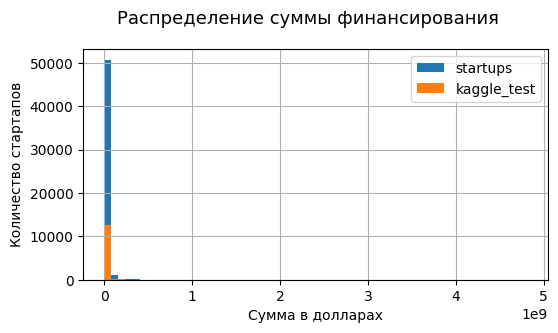

In [85]:
#построение гистограммы
axes = startups['funding_total_usd'].hist(figsize=(7,3), bins=60);
axes = kaggle_test['funding_total_usd'].hist(figsize=(6,3), bins=60);
# Общий заголовок для всех колонок
plt.suptitle('Распределение суммы финансирования', fontsize=13, y=1.01);
plt.legend(['startups','kaggle_test'])
# подпись осей
axes.set_xlabel('Сумма в долларах');
axes.set_ylabel('Количество стартапов');

**Посмотрим на данные в другом масштабе.**

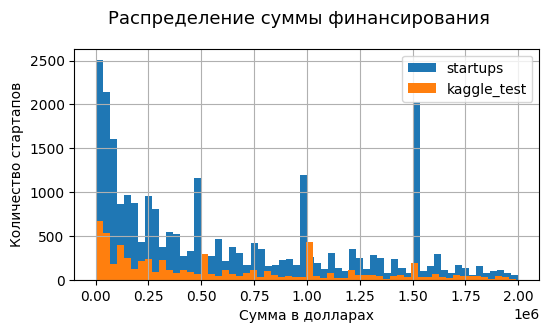

In [86]:
#построение гистограммы
axes = startups.query('funding_total_usd < 0.2e+7')['funding_total_usd'].hist(figsize=(7,3), bins=60);
axes = kaggle_test.query('funding_total_usd < 0.2e+7')['funding_total_usd'].hist(figsize=(6,3), bins=60);
# заголовок 
plt.suptitle('Распределение суммы финансирования', fontsize=13, y=1.01);
plt.legend(['startups','kaggle_test'])
# подпись осей
axes.set_xlabel('Сумма в долларах');
axes.set_ylabel('Количество стартапов');

**Структура данных по сумме финансирования имеет некоторые отличия, однако вообщем показатели описательной статистики схожи.**

**Сравнение количества раундов**

In [87]:
# объединение датафрейма с количеством раундов из startups с датафреймом, 
# содержащим количества раундов из kaggle_test по индексу из описательных статистик
pd.DataFrame(startups['funding_rounds'].describe()).\
    rename(columns={'funding_rounds':'funding_rounds_startups'}).\
        join(
          pd.DataFrame(kaggle_test['funding_rounds'].describe()).\
             rename(columns={'funding_rounds':'funding_rounds_kaggle_test'})  
        )

,funding_rounds_startups,funding_rounds_kaggle_test
count,52508.000000,13125.000000
mean,1.740344,1.714438
std,1.373537,1.318800
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,19.000000,15.000000


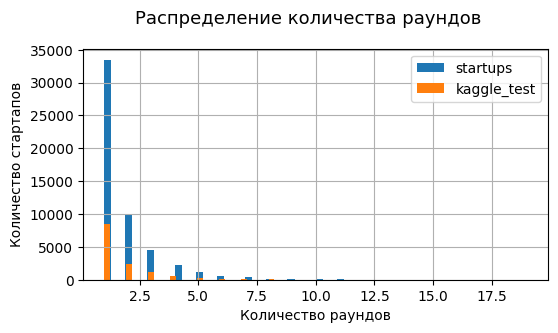

In [88]:
#построение гистограммы
axes = startups['funding_rounds'].hist(figsize=(7,3), bins=60);
axes = kaggle_test['funding_rounds'].hist(figsize=(6,3), bins=60);
# заголовок 
plt.suptitle('Распределение количества раундов', fontsize=13, y=1.01);
plt.legend(['startups','kaggle_test'])
# подпись осей
axes.set_xlabel('Количество раундов');
axes.set_ylabel('Количество стартапов');

**В тестовом датасете количество раундов следует похожей закономерности.**

**Аналогично показатели описательной статистики схожи.**

**Сравнение времени жизни стартапов**

In [89]:
# объединение датафрейма со сроками жизни стартапов из startups с датафреймом, 
# содержащим сроки жизни из kaggle_test по индексу из описательных статистик
pd.DataFrame(startups['lifetime'].describe()).\
    rename(columns={'lifetime':'lifetime_startups'}).\
        join(
          pd.DataFrame(kaggle_test['lifetime'].describe()).\
             rename(columns={'lifetime':'lifetime_kaggle_test'})  
        )

,lifetime_startups,lifetime_kaggle_test
count,52508.000000,13125.000000
mean,3140.297059,3097.609524
std,2146.872879,2128.356554
min,57.000000,52.000000
25%,1739.000000,1726.000000
50%,2557.000000,2526.000000
75%,4018.000000,3866.000000
max,17378.000000,17167.000000


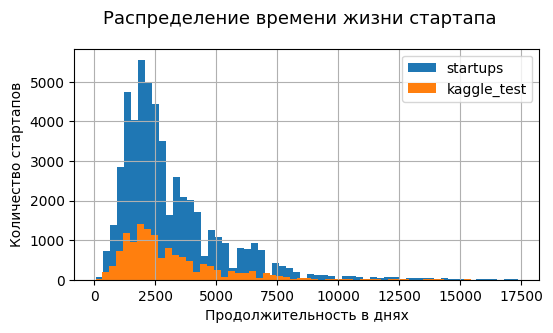

In [90]:
#построение гистограммы
axes = startups['lifetime'].hist(figsize=(7,3), bins=60);
axes = kaggle_test['lifetime'].hist(figsize=(6,3), bins=60);
# заголовок 
plt.suptitle('Распределение времени жизни стартапа', fontsize=13, y=1.01);
plt.legend(['startups','kaggle_test'])
# подпись осей
axes.set_xlabel('Продолжительность в днях');
axes.set_ylabel('Количество стартапов');

**Форма распределений времени жизни стартапов в startups и kaggle_test похожа (есть незначительные сдвиги), показатели описательной статистики схожи.**

Посмотрим на графики продолжительности стартапов отдельно.

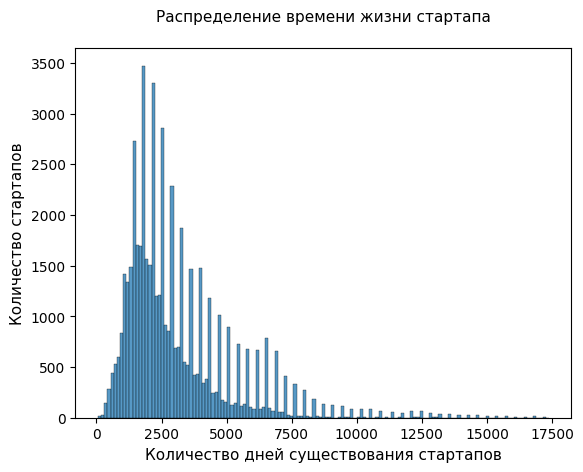

In [91]:
sns.histplot(x='lifetime', data=startups); 
# заголовок
plt.title(
    'Распределение времени жизни стартапа',\
    y=1.05, fontsize=11);
# подпись оси
plt.xlabel('Количество дней существования стартапов', fontsize=11);
plt.ylabel('Количество стартапов', fontsize=11);

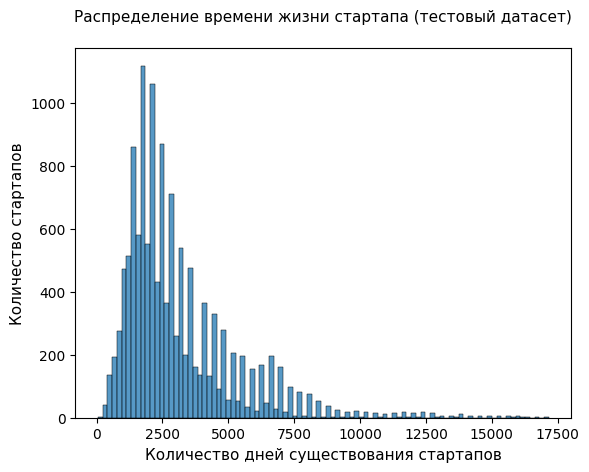

In [92]:
sns.histplot(x='lifetime', data=kaggle_test); 
# заголовок
plt.title(
    'Распределение времени жизни стартапа (тестовый датасет)',\
    y=1.05, fontsize=11);
# подпись оси
plt.xlabel('Количество дней существования стартапов', fontsize=11);
plt.ylabel('Количество стартапов', fontsize=11);

**Посмотрим на данные в числовых колонках во взаимосвязи между собой.**

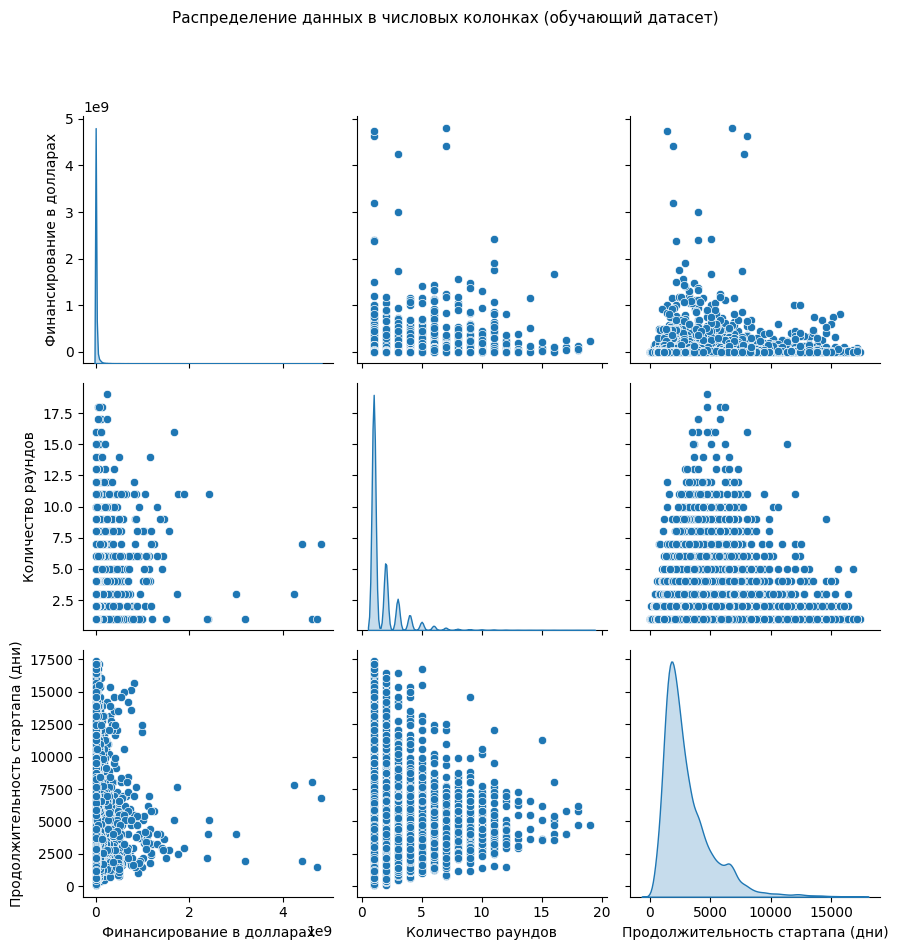

In [93]:
# двухмерный график сравнения
# параметры height и aspect для регулирования размера
# параметр hue для деления на подкатегории
# corner=True - убираем дублирующие графики
 # размер, прозрачность, вид точки на графике scatter
g = sns.pairplot(data=startups[['funding_total_usd', 'funding_rounds', 'lifetime']], \
             height=3,  aspect=1, diag_kind='kde');

# Заголовок можно получить, используя plt.gcf().suptitle()
plt.gcf().suptitle("Распределение данных в числовых колонках (обучающий датасет)", y=1.05, fontsize=11);

# Переименуем метки осей на графике с использованием ._add_axis_labels()
labels=["Финансирование в долларах","Количество раундов", "Продолжительность стартапа (дни)" ]
g.x_vars = labels
g.y_vars = labels
g._add_axis_labels()
plt.tight_layout()

In [94]:
startups.drop(columns={'status_new'}).corr() #корреляция

,funding_total_usd,funding_rounds,lifetime
funding_total_usd,1.000000,0.236363,0.114489
funding_rounds,0.236363,1.000000,0.145807
lifetime,0.114489,0.145807,1.000000


In [95]:
startups['funding_total_usd'].describe()

count    5.250800e+04
mean     1.417867e+07
std      7.452140e+07
min      1.000000e+00
25%      4.550000e+05
50%      2.000000e+06
75%      7.684971e+06
max      4.812000e+09
Name: funding_total_usd, dtype: float64

**Визуально видно, что продолжительность стартапа, финансирование в долларах, количество раундов не связаны линейной зависимостью (это также видно по коэффициентам корреляции).**   
**Половина проектов имеет сумму финансирования до 2 млн.руб.**  

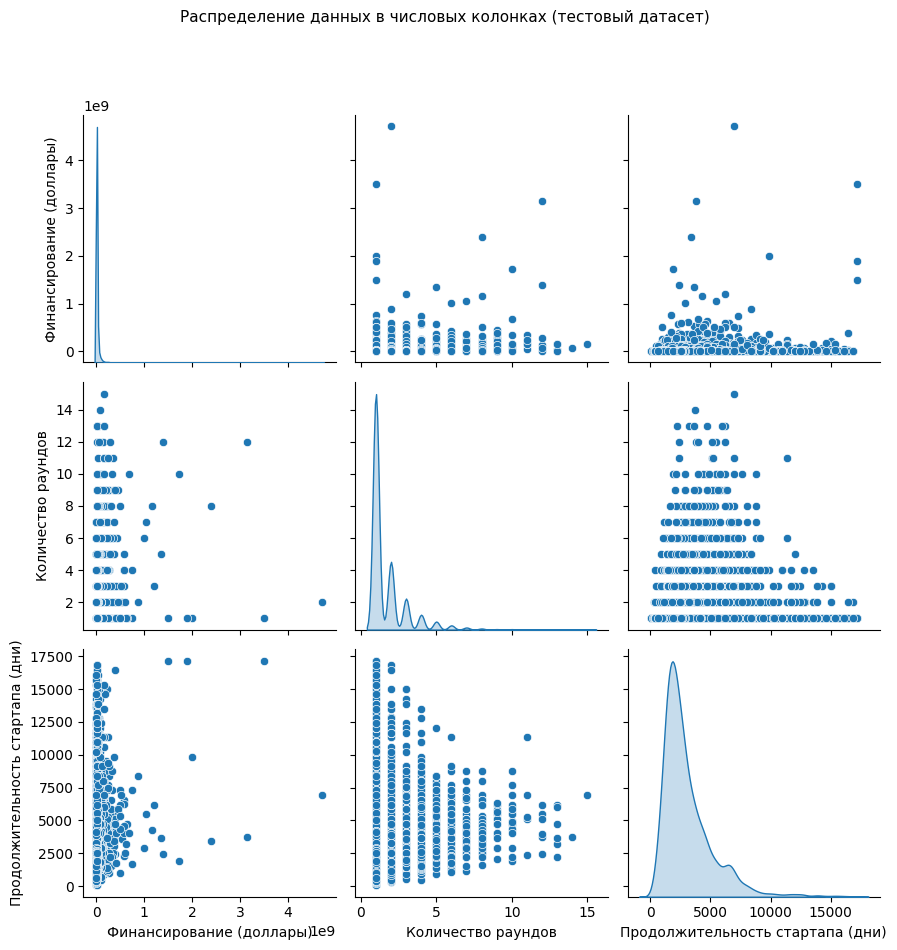

In [96]:
# двухмерный график сравнения
# параметры height и aspect для регулирования размера
# параметр hue для деления на подкатегории
# corner=True - убираем дублирующие графики
# размер, прозрачность, вид точки на графике scatter
g = sns.pairplot(data=kaggle_test[['funding_total_usd', 'funding_rounds', 'lifetime']], \
             height=3, aspect=1, diag_kind='kde');

# Заголовок можно получить, используя plt.gcf().suptitle()
plt.gcf().suptitle("Распределение данных в числовых колонках (тестовый датасет)", y=1.05, fontsize=11);

# Переименуем метки осей на графике с использованием ._add_axis_labels()
labels=["Финансирование (доллары)","Количество раундов", "Продолжительность стартапа (дни)" ]
g.x_vars = labels
g.y_vars = labels
g._add_axis_labels()
plt.tight_layout()

**Наблюдаем схожее распределение данных в тестовом датасете.**

#### Исследование категориальных колонок

**Статистика по категориальным колонкам**

In [97]:
# статистика для категориальных колонок
startups[startups.select_dtypes(include='object').columns.tolist()].drop(columns=['name', 'status']).describe()

,category_list,country_code,state_code,region,city,category_list_new
count,52508,52508,52508,52508,52508,52508
unique,22100,135,301,1037,4478,708
top,Software,USA,CA,SF Bay Area,Unknown,Biotechnology
freq,3207,29697,10218,6969,6357,3592


In [98]:
# статистика для категориальных колонок
kaggle_test[kaggle_test.select_dtypes(include='object').columns.tolist()].drop(columns=['name']).describe()

,category_list,country_code,state_code,region,city,category_list_new
count,13125,13125,13125,13125,13125,13125
unique,6207,97,236,689,2118,560
top,Software,USA,CA,SF Bay Area,Unknown,Biotechnology
freq,775,7428,2552,1750,1587,855


**В категориальных колонках наиболее частая категория в датафреймах startups и kaggle_test совпадают. Частота примерно пропорцинальна в соответствии с размерами датафреймов.**

**Исследование категории деятельности**

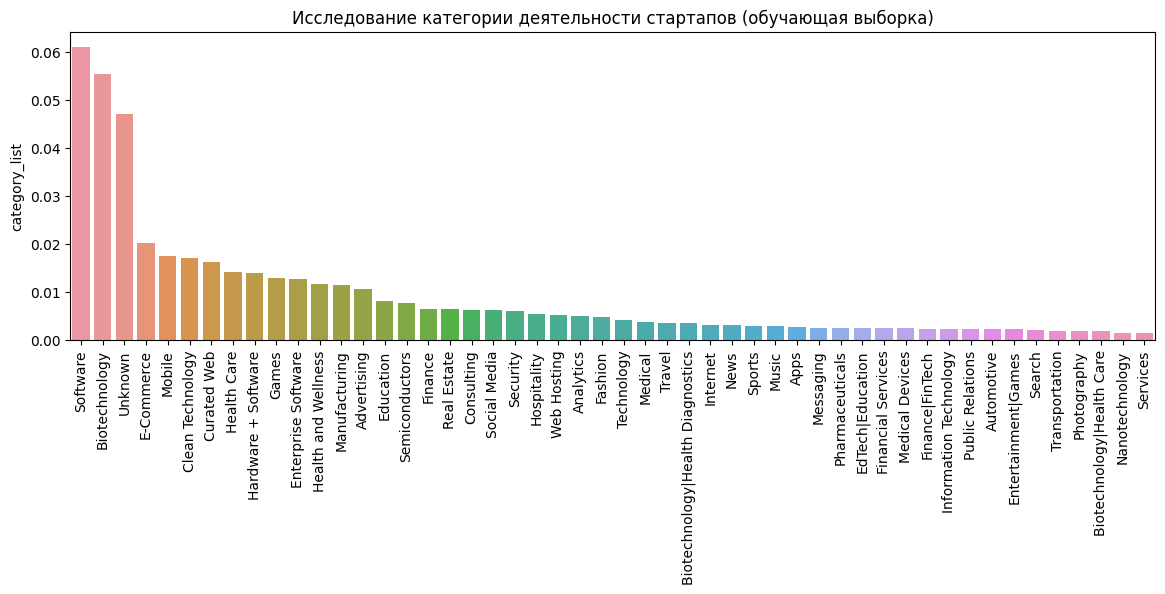

In [99]:
plt.figure(figsize=(14,4))
dd = pd.DataFrame(startups['category_list'].value_counts(normalize=True)).head(50) # доли категорий
sns.barplot(x=dd.index, y=dd['category_list'])
plt.xticks(rotation=90);
plt.title('Исследование категории деятельности стартапов (обучающая выборка)');

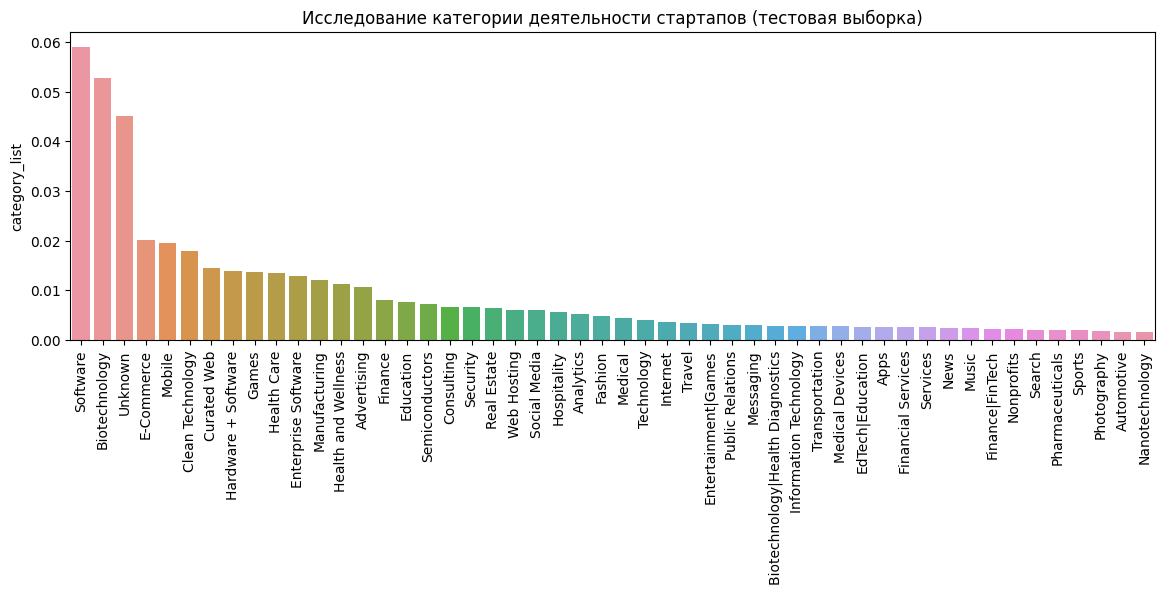

In [100]:
plt.figure(figsize=(14,4))
dd = pd.DataFrame(kaggle_test['category_list'].value_counts(normalize=True)).head(50) # доли категорий
sns.barplot(x=dd.index, y=dd['category_list'])
plt.xticks(rotation=90);
plt.title('Исследование категории деятельности стартапов (тестовая выборка)');

**Категории для датасетов startups и kaggle_test в основном следуют в том же порядке, хотя и есть некоторые различия.**

**Посмотрим на пропорции в первых десяти категориях.**

In [101]:
ss = pd.DataFrame(startups['category_list'].value_counts(normalize=True)).head(10) # доли категорий
ss = ss.rename(columns={'category_list':'category_list_startups'})
kk = pd.DataFrame(kaggle_test['category_list'].value_counts(normalize=True)).head(10) # доли категорий
kk = kk.rename(columns={'category_list':'category_list_kaggle_test'})
ss.join(kk)

,category_list_startups,category_list_kaggle_test
Software,0.061076,0.059048
Biotechnology,0.055325,0.052800
Unknown,0.046945,0.045029
E-Commerce,0.020264,0.020038
Mobile,0.017521,0.019429
Clean Technology,0.016988,0.017829
Curated Web,0.016245,0.014552
Health Care,0.014169,0.013410
Hardware + Software,0.013960,0.013790
Games,0.012969,0.013714


**Это общее в структуре позволяет нам сделать переход от категориальных значений к числовым. Вместо категорий рассматривать их доли. Также можно было бы перейти к когортам.** 

**Аналогично рассмотрим остальные категориальные столбцы.**

**Исследование страны регистрации стартапа**

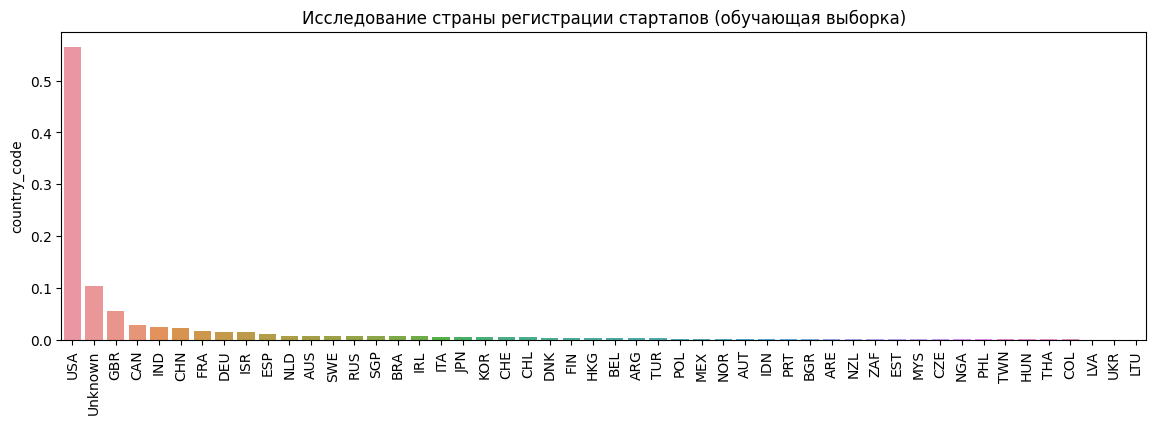

In [102]:
plt.figure(figsize=(14,4))
dd = pd.DataFrame(startups['country_code'].value_counts(normalize=True)).head(50) # доли категорий
sns.barplot(x=dd.index, y=dd['country_code'])
plt.xticks(rotation=90);
plt.title('Исследование страны регистрации стартапов (обучающая выборка)');

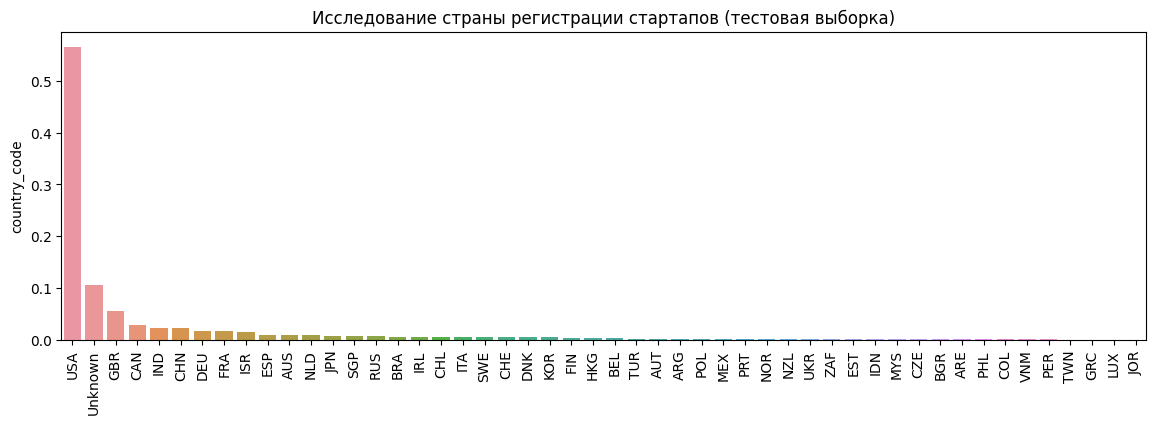

In [103]:
plt.figure(figsize=(14,4))
dd = pd.DataFrame(kaggle_test['country_code'].value_counts(normalize=True)).head(50) # доли категорий
sns.barplot(x=dd.index, y=dd['country_code'])
plt.xticks(rotation=90);
plt.title('Исследование страны регистрации стартапов (тестовая выборка)');

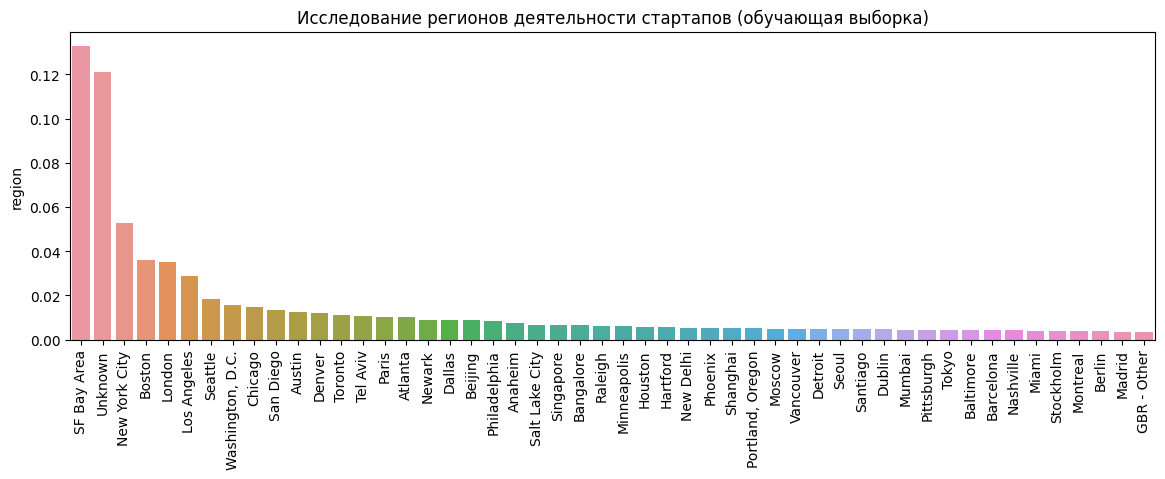

In [104]:
plt.figure(figsize=(14,4))
dd = pd.DataFrame(startups['region'].value_counts(normalize=True)).head(50) # доли категорий
sns.barplot(x=dd.index, y=dd['region'])
plt.xticks(rotation=90);
plt.title('Исследование регионов деятельности стартапов (обучающая выборка)');

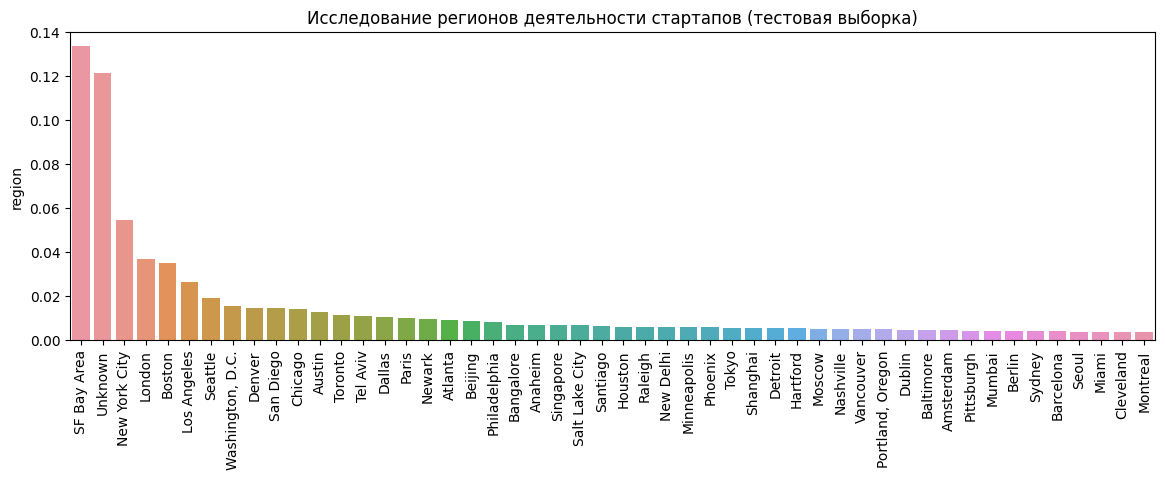

In [105]:
plt.figure(figsize=(14,4))
dd = pd.DataFrame(kaggle_test['region'].value_counts(normalize=True)).head(50) # доли категорий
sns.barplot(x=dd.index, y=dd['region'])
plt.xticks(rotation=90);
plt.title('Исследование регионов деятельности стартапов (тестовая выборка)');

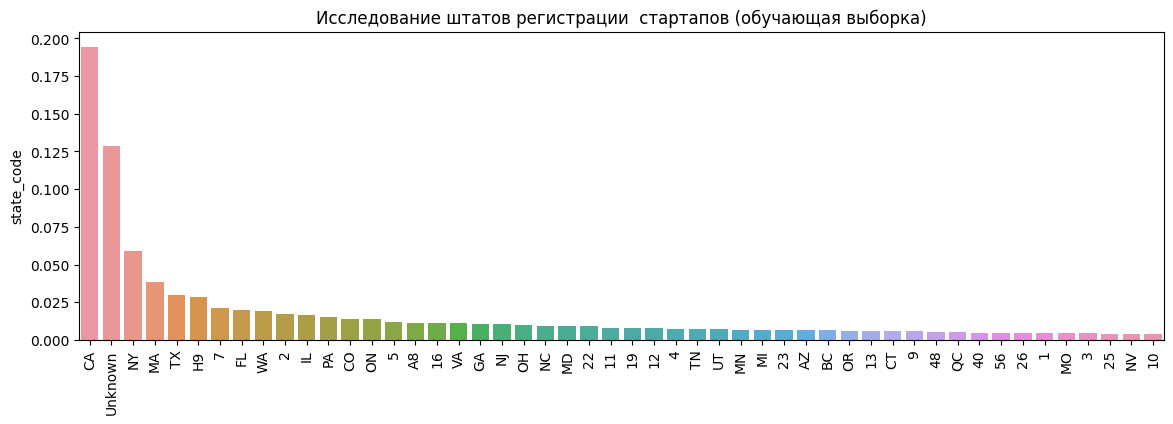

In [106]:
plt.figure(figsize=(14,4))
dd = pd.DataFrame(startups['state_code'].value_counts(normalize=True)).head(50) # доли категорий
sns.barplot(x=dd.index, y=dd['state_code'])
plt.xticks(rotation=90);
plt.title('Исследование штатов регистрации  стартапов (обучающая выборка)');

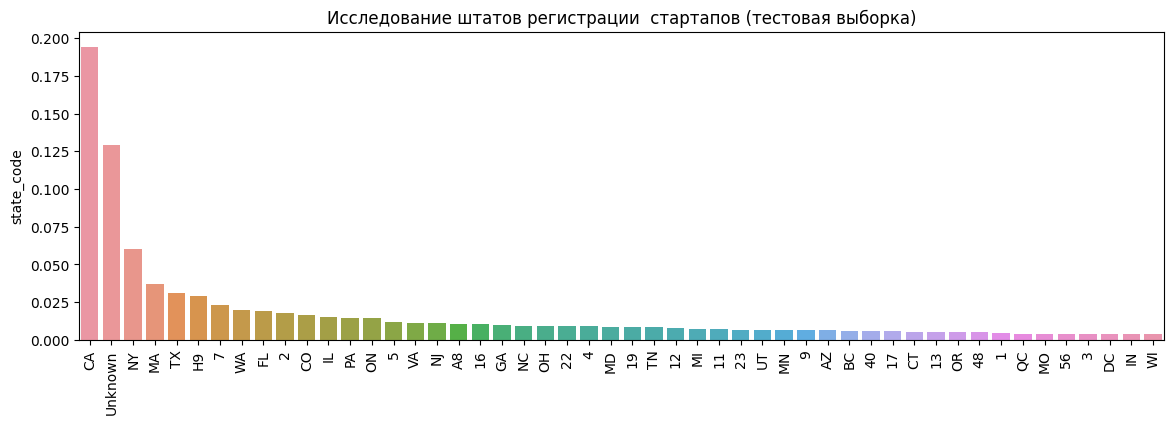

In [107]:
plt.figure(figsize=(14,4))
dd = pd.DataFrame(kaggle_test['state_code'].value_counts(normalize=True)).head(50) # доли категорий
sns.barplot(x=dd.index, y=dd['state_code'])
plt.xticks(rotation=90);
plt.title('Исследование штатов регистрации  стартапов (тестовая выборка)');

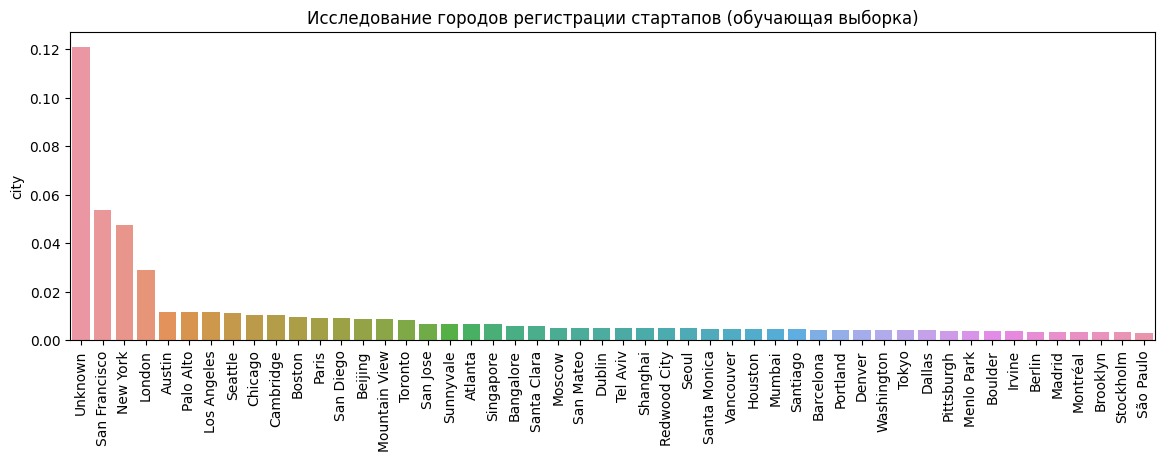

In [108]:
plt.figure(figsize=(14,4))
dd = pd.DataFrame(startups['city'].value_counts(normalize=True)).head(50) # доли категорий
sns.barplot(x=dd.index, y=dd['city'])
plt.xticks(rotation=90);
plt.title('Исследование городов регистрации стартапов (обучающая выборка)');

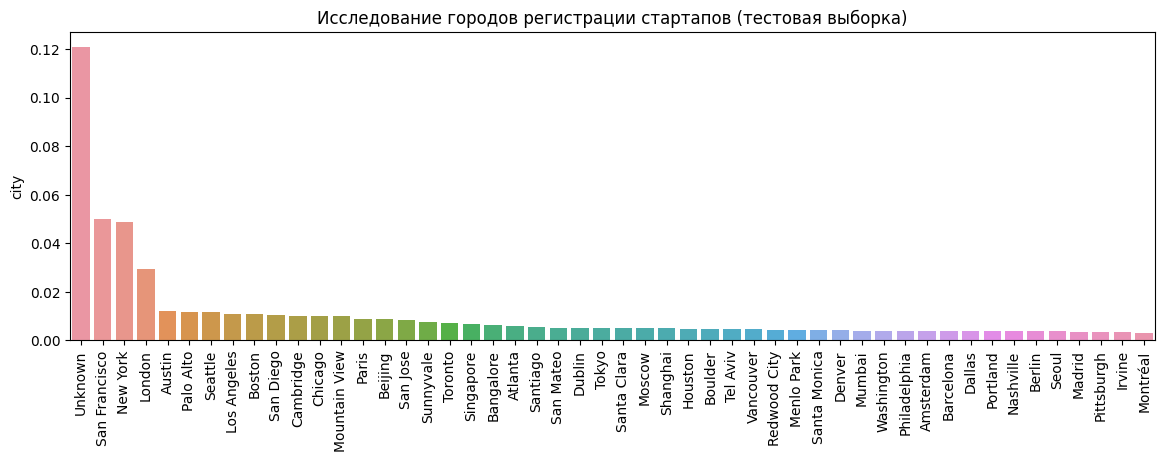

In [109]:
plt.figure(figsize=(14,4))
dd = pd.DataFrame(kaggle_test['city'].value_counts(normalize=True)).head(50) # доли категорий
sns.barplot(x=dd.index, y=dd['city'])
plt.xticks(rotation=90);
plt.title('Исследование городов регистрации стартапов (тестовая выборка)');

**Прослеживается общее в структуре всех категориальных признаков для обучающего и тестового датасетов.**

### Исследовательский анализ обучающего датасета (startups)

**Посмотрим на целевой признак.**

In [110]:
startups['status'].value_counts(normalize=True)

operating    0.906376
closed       0.093624
Name: status, dtype: float64

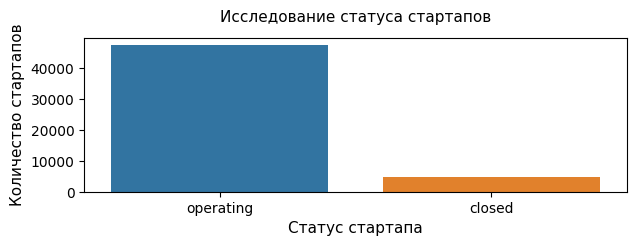

In [111]:
plt.figure(figsize=(7,2))
sns.countplot(data=startups, x='status');
# названия осей
plt.xlabel('Статус стартапа', fontsize=11);
plt.ylabel('Количество стартапов', fontsize=11);
# заголовок
plt.title('Исследование статуса стартапов', y=1.05, fontsize=11);

**Видим, что данные не сбалансированы: закрытых стартапов - 9.4%, открытых - 90.6%.**

**Исследуем данные в разрезе целевого признака.**

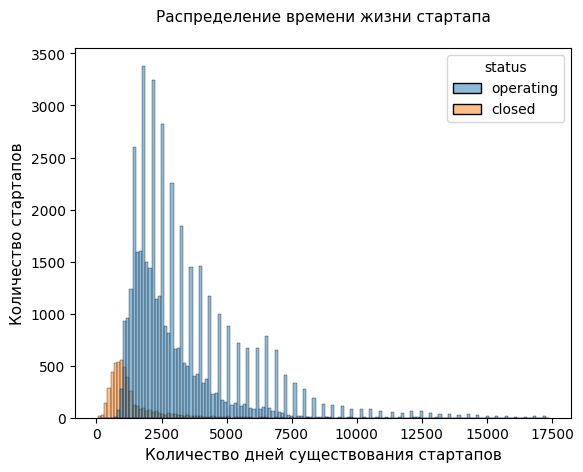

In [112]:
sns.histplot(x='lifetime', data=startups, hue='status'); 
# заголовок
plt.title(
    'Распределение времени жизни стартапа',\
    y=1.05, fontsize=11);
# подпись оси
plt.xlabel('Количество дней существования стартапов', fontsize=11);
plt.ylabel('Количество стартапов', fontsize=11);

* **Формы распределения времени жизни стартапа для закрытых и открытых стартапов похожи, однако есть отдельные пики для открытых стартапов.**   
* **Вполне логично, что закрытые стартапы имеют меньшее количество дней существания.**

**Видим, что формы распределений времени жизни стартапа для обучающего и тестового датасетов очень похожи.**

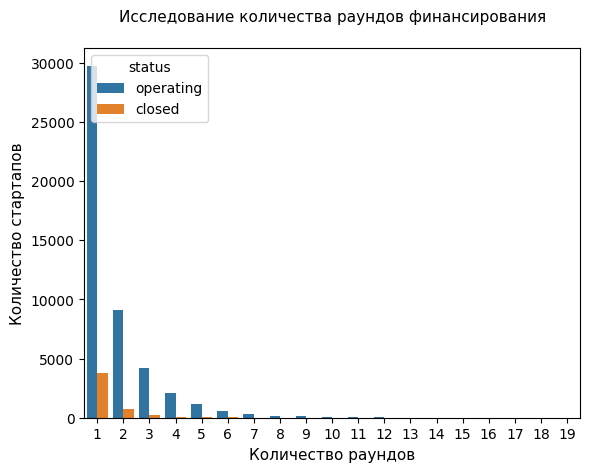

In [113]:
sns.countplot(x='funding_rounds', data=startups, hue='status'); 
# заголовок
plt.title(
    'Исследование количества раундов финансирования',\
    y=1.05, fontsize=11);
# подпись оси
plt.xlabel('Количество раундов', fontsize=11);
plt.ylabel('Количество стартапов', fontsize=11);

**Количество раундов для закрытых и открытых стартапов изменяется в схожих пропорциях.**

**Посмотрим на данные в числовых колонках во взаимосвязи между собой.**

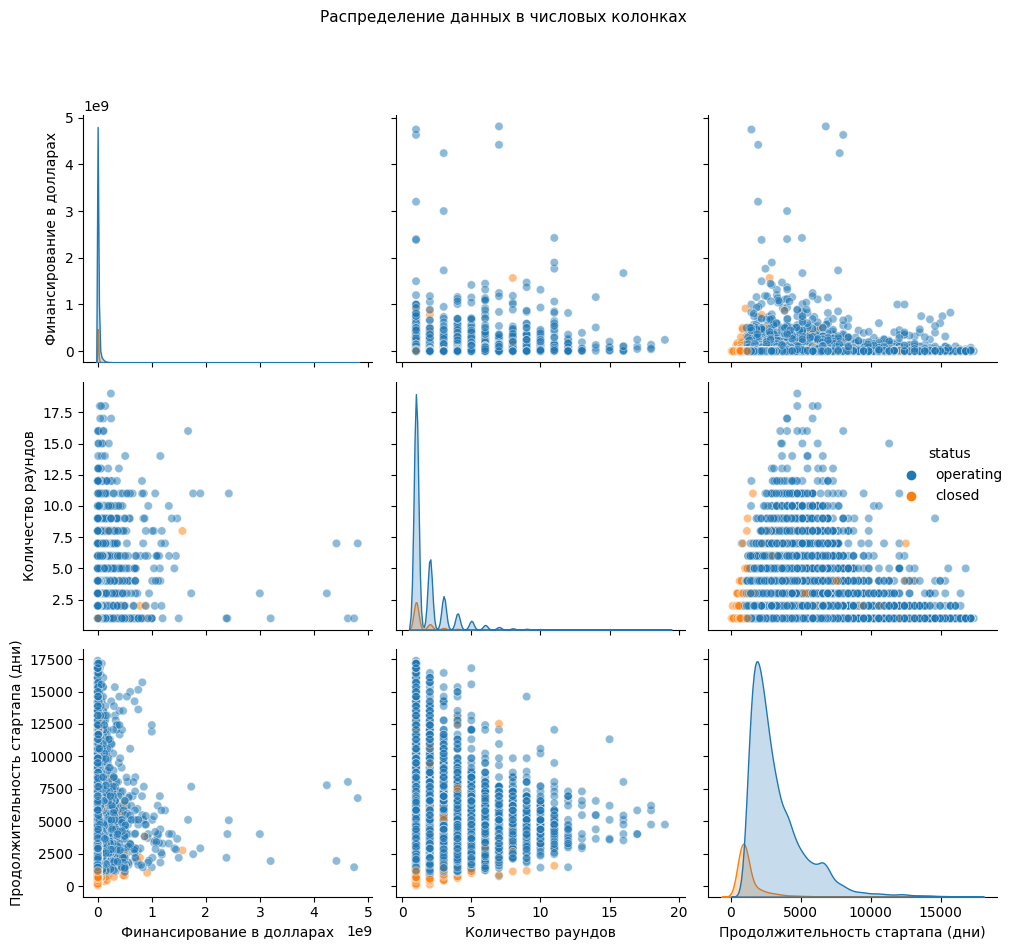

In [114]:
# двухмерный график сравнения
# параметры height и aspect для регулирования размера
# параметр hue для деления на подкатегории
# corner=True - убираем дублирующие графики
scatter_kws = {'alpha': 0.5} # размер, прозрачность, вид точки на графике scatter
data = startups[['funding_total_usd', 'funding_rounds', 'lifetime', 'status']]    
g = sns.pairplot(data=data, height=3, hue='status', aspect=1, diag_kind='kde', plot_kws=scatter_kws);

# Заголовок можно получить, используя plt.gcf().suptitle()
plt.gcf().suptitle("Распределение данных в числовых колонках", y=1.05, fontsize=11);

# Переименуем метки осей на графике с использованием ._add_axis_labels()
labels=["Финансирование в долларах","Количество раундов", "Продолжительность стартапа (дни)" ]
g.x_vars = labels
g.y_vars = labels
g._add_axis_labels()
plt.tight_layout()

In [115]:
startups.drop(columns={'status_new'}).corr() #корреляция

,funding_total_usd,funding_rounds,lifetime
funding_total_usd,1.000000,0.236363,0.114489
funding_rounds,0.236363,1.000000,0.145807
lifetime,0.114489,0.145807,1.000000


In [116]:
startups['funding_total_usd'].describe()

count    5.250800e+04
mean     1.417867e+07
std      7.452140e+07
min      1.000000e+00
25%      4.550000e+05
50%      2.000000e+06
75%      7.684971e+06
max      4.812000e+09
Name: funding_total_usd, dtype: float64

**На графиках видно, что закрытые проекты имеют меньшую продолжительность. Этот признак, вероятно, будет обладать высокой важностью при классификации стартапа.**  

**Исследуем некоторые категориальные данные в разрезе целевого признака.**

**Посмотрим, в каких странах наибольшая доля закрытых стартапов и в каких наибольшее количество.**

In [117]:
def func_status(sort_column='Доля класса Закрыт', index='country_code'):
    plt.figure(dpi=100, figsize=(10,3)) # размер, четкость
    # группировка: в строках - index, в столбцах - 'status', агрегирующая функция - количество
    data = startups.pivot_table(
        index = index, 
        columns = 'status', 
        aggfunc='count', 
        values='name')
    data['Доля класса Открыт'] = (
        data['operating'] / (data['operating'] + data['closed'])
    ).round(2)
    data['Доля класса Закрыт'] = 1 - data['Доля класса Открыт']
    data = data.fillna(0).query('closed > 0').sort_values(by=sort_column, ascending=False)
    data = data.head(10)
    display(data);

In [118]:
'''
Функция строит тепловую карту для открытых и закрытых стартапов в разрезе
городов, регионов, штатов
Возможные значения sort_column: 'Доля класса Закрыт','Доля класса Открыт'.

Возможные значения index: 'country_code', 'state_code',	'region', 'city'.	
'''
def func_country_status(sort_column='Доля класса Закрыт', index='country_code'):
    plt.figure(dpi=100, figsize=(10,3)) # размер, четкость

    data = startups.pivot_table(
        index = index, 
        columns = 'status', 
        aggfunc='count', 
        values='name')
    data['Доля класса Открыт'] = (
        data['operating'] / (data['operating'] + data['closed'])
    ).round(2)
    data['Доля класса Закрыт'] = 1 - data['Доля класса Открыт']
    data = data.fillna(0).query('closed > 0').sort_values(by=sort_column, ascending=False)
    data = data.head(10)
    # Заголовок
    plt.title('Распределение доли классов', y=1.05, fontsize=11);
    # подписи на осях
    # тепловая карта. "удаление" меток осей сделали с помощью .set(xlabel='', ylabel='')
    
    sns.heatmap(
        data=data[
        ['Доля класса Открыт', 'Доля класса Закрыт']
        ], linewidth=0.5, cmap='Reds', annot=True, fmt='.3').set(xlabel='', ylabel='');
    


In [119]:
func_status(sort_column='Доля класса Закрыт', index='country_code')

status,closed,operating,Доля класса Открыт,Доля класса Закрыт
country_code,,,,
MKD,1.0,1.0,0.50,0.50
RUS,130.0,238.0,0.65,0.35
BLR,1.0,2.0,0.67,0.33
GEO,1.0,2.0,0.67,0.33
PRI,1.0,2.0,0.67,0.33
SLV,1.0,2.0,0.67,0.33
LIE,1.0,2.0,0.67,0.33
PER,9.0,25.0,0.74,0.26
SAU,2.0,6.0,0.75,0.25


<Figure size 1000x300 with 0 Axes>

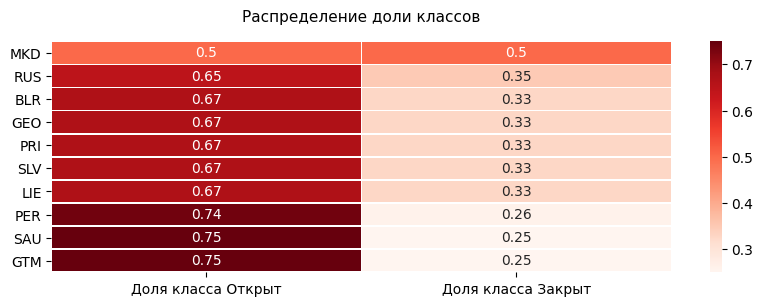

In [120]:
func_country_status(sort_column='Доля класса Закрыт', index='country_code')

**Наибольшая доля закрытых стартапов в странах с тикерами MKD, RUS, BLR и т.д. Однако у нас недостаточно данных для этих стран, так что это может быть просто шум, случайность.**

In [121]:
func_status(sort_column='closed', index='country_code')

status,closed,operating,Доля класса Открыт,Доля класса Закрыт
country_code,,,,
USA,2283.0,27414.0,0.92,0.08
Unknown,1286.0,4214.0,0.77,0.23
GBR,234.0,2691.0,0.92,0.08
RUS,130.0,238.0,0.65,0.35
CAN,128.0,1412.0,0.92,0.08
FRA,71.0,845.0,0.92,0.08
ISR,64.0,703.0,0.92,0.08
DEU,61.0,773.0,0.93,0.07
CHN,54.0,1186.0,0.96,0.04


<Figure size 1000x300 with 0 Axes>

**Наибольшее количество закрытых стартапов в США, однако в относительных величинах это небольшое количество.**

In [122]:
func_status(sort_column='Доля класса Открыт', index='country_code')

status,closed,operating,Доля класса Открыт,Доля класса Закрыт
country_code,,,,
PRT,1.0,85.0,0.99,0.01
CHL,8.0,244.0,0.97,0.03
TUR,6.0,137.0,0.96,0.04
IND,53.0,1223.0,0.96,0.04
HUN,2.0,43.0,0.96,0.04
CHN,54.0,1186.0,0.96,0.04
THA,2.0,43.0,0.96,0.04
ARE,3.0,75.0,0.96,0.04
POL,6.0,114.0,0.95,0.05


<Figure size 1000x300 with 0 Axes>

**Наибольшая доля открытых стартапов в PRT, CHL, TUR. Однако количество стартапов в этих странах мало в общем объеме данных.**

In [123]:
func_status(sort_column='operating', index='country_code')

status,closed,operating,Доля класса Открыт,Доля класса Закрыт
country_code,,,,
USA,2283.0,27414.0,0.92,0.08
Unknown,1286.0,4214.0,0.77,0.23
GBR,234.0,2691.0,0.92,0.08
CAN,128.0,1412.0,0.92,0.08
IND,53.0,1223.0,0.96,0.04
CHN,54.0,1186.0,0.96,0.04
FRA,71.0,845.0,0.92,0.08
DEU,61.0,773.0,0.93,0.07
ISR,64.0,703.0,0.92,0.08


<Figure size 1000x300 with 0 Axes>

**Наибольшее количество открытых стартапов в разрезе целевого признака в USA, Unknown (неизвестная категория), GBR.**

**Посмотрим на распределение доли классов в зависимости от категории деятельности в абсолютных и относительных количествах.**

In [124]:
func_status(sort_column='Доля класса Закрыт', index='category_list_new')

status,closed,operating,Доля класса Открыт,Доля класса Закрыт
category_list_new,,,,
Interest Graph,4.0,1.0,0.20,0.80
Internet TV,2.0,1.0,0.33,0.67
Intelligent Systems,4.0,4.0,0.50,0.50
In-Flight Entertainment,1.0,1.0,0.50,0.50
Portals,1.0,1.0,0.50,0.50
Promotional,1.0,1.0,0.50,0.50
Logistics Company,1.0,1.0,0.50,0.50
Q&A,1.0,1.0,0.50,0.50
Anything Capital Intensive,1.0,1.0,0.50,0.50


<Figure size 1000x300 with 0 Axes>

**Наибольшая доля закрытых стартапов в разрезе целевого признака по категориям Interest Graph, Internet TV, Intelligent Systems. Однако в абсолютных величинах в этих категориях небольшое количество стартапов.**

In [125]:
func_status(sort_column='closed', index='category_list_new')

status,closed,operating,Доля класса Открыт,Доля класса Закрыт
category_list_new,,,,
Unknown,729.0,1736.0,0.70,0.30
Curated Web,332.0,1415.0,0.81,0.19
Software,282.0,3040.0,0.92,0.08
Biotechnology,207.0,3385.0,0.94,0.06
Advertising,181.0,1745.0,0.91,0.09
E-Commerce,179.0,1994.0,0.92,0.08
Mobile,133.0,1263.0,0.90,0.10
Games,118.0,896.0,0.88,0.12
Apps,115.0,1069.0,0.90,0.10


<Figure size 1000x300 with 0 Axes>

**Наибольшее абсолютное количество закрытых стартапов по неизвестной категории деятельности Unknown, далее Curated Web, Software.**  

**Вывод:**     
* Проведя исследовательский анализ данных, можно сделать вывод, что определяющим признаком классификации стартапов является продолжительность существования стартапа.   
* Также было замечено, что распределение данных в обучающем и тестовом датасетах очень схоже.   
* Категорий в категориальных колонках очень много, что говорит о том, что желательно перейти от категориальных признаков к числовым. В связи с этим, возникает необходимость создания новых синтетических столбцов на основе существующих.  

## Синтетические столбцы

**Создадим искусственные столбцы:**       
1. **data['dur_rounds']** - Продолжительность раундов (по аналогии с lifetime).   
2.  **data['first_funding_at_num']** - Преобразуем дату в столбце 'first_funding_at' в числа, обозначающие количество дней с 1 января 1970 года. Для 'last_funding_at' так делать не будем, так как есть столбец с продолжительностью раундов (иначе получится мультиколлинеарность, так как есть линейная зависимость между 'first_funding_at_num' и 'last_funding_at_num').   
4. **data['count_category_list']**- Количество категорий в колонке 'category_list'.   
5. **data['country_code_share']**,  **data['city_share']**,  **data['category_list_share']** - Найдем долю каждой страны, каждого города, каждой категории в данных.   
6. **data['total_1day_lifetime']** - Сумма на 1 день жизни статапа (вычисляется как data['funding_total_usd'] / data['lifetime']).
   
**Итого 8 новых столбцов.**

**Все это оформим ввиде функции columns_new(data), так как для тестового датафрейма надо проделать тоже самое.** Эта функция внутри себя содержит подфункцию func_merge(data, col).

**Создадим функцию func_merge(data, col), с помощью которой в датафрейм добавляется новый столбец с долями каждой категории, вычисленными по нужному категориальному столбцу.** Эту функция вызывается внутри функции columns_new(data).

In [126]:
'''
Функция создает синтетические столбцы 'dur_rounds', 'av_dur_rounds', 'first_funding_at_num',
'last_funding_at_num'
Пример вызова:
startups = columns_new(startups)
'''
def columns_new(data):

    def func_merge(data, col):
        #col - столбец с категориями
        #col_share - столбец, полученный из col, содержит долю категории
        #Пример вызова функции:
        #func_merge(startups,'country_code')
        #Возвращает датафрейм, в котором добавлен новый столбец col_share
        tt = pd.DataFrame(data[col].value_counts(normalize=True)).rename(columns={col:col+'_share'})
        tt = tt.reset_index()
        tt = tt.rename(columns={'index':col})
        data = data.merge(tt, how='inner', on=col)
        return data

    #вычисляем количество категорий в столбце 'category_list'
    data['count_category_list'] = data['category_list'].str.count('|') + 1
    #Создадим столбец продолжительность раундов (по аналогии с lifetime).
    # чтобы избежать далее деления на ноль, прибавляем 1
    data['dur_rounds'] = data['last_funding_at'] - data['first_funding_at'] 
    data['dur_rounds'] = data['dur_rounds'].astype(str).str.split(' ').str[0].astype(int) + 1
    #Создадим искусственный столбец - средняя продолжительность раунда в днях.
 
    #Теперь надо сохранить информацию из дат - для этого преобразуем даты в числа
    data['first_funding_at_num'] = data['first_funding_at'] - datetime.datetime(1970,1,1)
    data['first_funding_at_num'] = data['first_funding_at_num'].astype(str).str.split(' ').str[0].astype(int)
    #data['last_funding_at_num'] = data['last_funding_at'] - datetime.datetime(1970,1,1)
    #data['last_funding_at_num'] = data['last_funding_at_num'].astype(str).str.split(' ').str[0].astype(int)
    #вычисляем долю каждой страны в данных
    data = func_merge(data,'country_code')
    #data = func_merge(data,'region')
    data = func_merge(data,'city')
    #data = func_merge(data,'category_list_new')
    data = func_merge(data,'category_list')

    # сумма на 1 день жизни проекта
    data['total_1day_lifetime'] = data['funding_total_usd'] / data['lifetime']

    # сделаем индексом столбец 'name'
    data = data.set_index('name')
    return data
    

In [127]:
startups = columns_new(startups)
kaggle_test = columns_new(kaggle_test)

In [128]:
startups.head(3)

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,status_new,category_list_new,count_category_list,dur_rounds,first_funding_at_num,country_code_share,city_share,category_list_share,total_1day_lifetime
name,,,,,,,,,,,,,,,,,,,,
Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,2998,0,Online Reservations,33,1311,15095,0.00499,0.001447,0.000019,276.392929
42matters AG,Advertising|Android|Curated Web|Mobile|Promotional,138000.0,operating,CHE,25,Zurich,Zürich,2,2011-09-12,2014-02-09,2414,0,Advertising,52,882,15229,0.00499,0.001447,0.000019,57.166529
Doodle,Advertising|Curated Web|Events|Internet|Meeting Software|Online Scheduling,138000.0,operating,CHE,25,Zurich,Zürich,1,2008-01-01,2008-01-01,3959,0,Advertising,76,1,13879,0.00499,0.001447,0.000019,34.857287


**Мы создали искусственные данные, собрав в числовые столбцы информацию из текстовых.**

In [129]:
# посмотрим только на числовые столбцы
startups[startups.select_dtypes(include='number').columns.tolist()].head(3)

,funding_total_usd,funding_rounds,lifetime,status_new,count_category_list,dur_rounds,first_funding_at_num,country_code_share,city_share,category_list_share,total_1day_lifetime
name,,,,,,,,,,,
Lunchgate,828626.0,2,2998,0,33,1311,15095,0.00499,0.001447,0.000019,276.392929
42matters AG,138000.0,2,2414,0,52,882,15229,0.00499,0.001447,0.000019,57.166529
Doodle,138000.0,1,3959,0,76,1,13879,0.00499,0.001447,0.000019,34.857287


In [130]:
# Функция возвращает датафрейм только с числами
def func_data_number(data):
    return data[data.select_dtypes(include='number').columns.tolist()] #датафрейм только с числами

**Создадим датафрейм df из startups, содержащий только числовые колонки.**

In [131]:
df = func_data_number(startups)
df.sample()

,funding_total_usd,funding_rounds,lifetime,status_new,count_category_list,dur_rounds,first_funding_at_num,country_code_share,city_share,category_list_share,total_1day_lifetime
name,,,,,,,,,,,
"Snippit Media, Inc.",500000.0,1,1696,0,7,1,16071,0.565571,0.000457,0.002876,294.811321


**Создадим полностью числовой датафрейм kaggle_test_number на основе kaggle_test. С помощью kaggle_test_number будем делать результирующие предсказания, которые необходимо отправить в kaggle.**

In [132]:
# аналогично на основе kaggle_test создаем полностью числовой датафрейм
kaggle_test_number = func_data_number(kaggle_test)
kaggle_test_number.head(3)

,funding_total_usd,funding_rounds,lifetime,count_category_list,dur_rounds,first_funding_at_num,country_code_share,city_share,category_list_share,total_1day_lifetime
name,,,,,,,,,,
Crystalsol,2819200.0,1,3501,18,1,14426,0.000076,0.120914,0.017829,805.255641
ALUHEAT,2486835.0,1,3267,18,1,14848,0.105295,0.120914,0.017829,761.198347
Airsynergy,2573200.0,1,2034,18,1,16128,0.105295,0.120914,0.017829,1265.093412


**Мы подготовили и преобразовали данные. Теперь на этих данных (датафрейм df) обучим 2 модели - RandomForestClassifier() и CatBoostClassifier().**

## Весь код до моделирования 

**В этом параграфе собран весь код, который мы делали, до процесса моделирования.**

``` python
def func_read():
    # считываем csv-файлы
    try:
        startups = pd.read_csv('kaggle_startups_train_28062024.csv')
        kaggle_test = pd.read_csv('kaggle_startups_test_28062024.csv')
    except:
        try:
            startups = pd.read_csv('kaggle_startups_train_28062024.csv')
            kaggle_test = pd.read_csv('kaggle_startups_test_28062024.csv')
        except:
            startups = pd.read_csv('kaggle_startups_train_28062024.csv')
            kaggle_test = pd.read_csv('kaggle_startups_test_28062024.csv')
    return startups, kaggle_test
#---------------    
startups, kaggle_test = func_read() # загрузка обучающего и тестового датасетов
#---------------
# приведение к одинаковому признаковому пространству обучающего датасета (startups)
def same_structure(data):
    #Заполним пропуски в колонке closed_at. Вместо NaN укажем дату выгрузки «2018-01-01». 
    data['closed_at'] = data['closed_at'].fillna('2018-01-01')
    # преобразование в формат datetime
    data['founded_at'] = pd.to_datetime(data['founded_at'], format='%Y-%m-%d')
    data['closed_at'] = pd.to_datetime(data['closed_at'], format='%Y-%m-%d')
    data['lifetime'] = data['closed_at']-data['founded_at']
    data['lifetime'] = data['lifetime'].astype(str).str.split(' ').str[0].astype(int)
    #удаление столбцов 'closed_at' и 'founded_at' из датафрейма 'startups'.
    data = data.drop(['closed_at', 'founded_at'], axis=1)
    #создание целевой колонки с 0 и 1, можно и не делать, но это дает нам уверенность в кодировании,
    #чтобы не проверять, что и как закодировано
    data['status_new'] = data['status'].map({'operating': 0, 'closed':1}) 
    return data
#--------------
startups = same_structure(startups) # приведение к одинаковым признакам
#--------------
# можно использовать только для удаления строк в обучающем датасете (startups)
# удаление, но можно попробовать и без удаления
startups = startups.query('funding_total_usd <= 4.815000e+09 and lifetime>52 or funding_total_usd.isnull()')
#--------------
def start_preprocessing(data):
    #Заполним пропуски в категориальных колонках 
    data[['name', 'category_list', 'country_code', 'region', 'city', 'state_code']] = \
    data[['name','category_list', 'country_code', 'region', 'city', 'state_code']].fillna('None')
    
    # преобразование в формат datetime
    data['first_funding_at'] = pd.to_datetime(data['first_funding_at'], format='%Y-%m-%d')
    data['last_funding_at'] = pd.to_datetime(data['last_funding_at'], format='%Y-%m-%d')
   
    #Добавим столбец category_list_new с основной категорией деятельности.
    data['category_list_new'] = data['category_list'].str.split('|').str[0] 
    #заполнение пропусков с учетом страны и категории деятельности
    temp = pd.DataFrame(data.groupby(['country_code', 'category_list_new'])['funding_total_usd'].agg('median'))
    temp = temp.reset_index().rename(columns = {'funding_total_usd':'temp_sum'})
    funding_total_usd_median = data['funding_total_usd'].median()
    data = data.merge(temp, on = ['country_code', 'category_list_new'], how = 'outer')
    data['funding_total_usd'] = data['funding_total_usd'].fillna(0)
    def func_total(funding_total_usd, temp_sum):
        if funding_total_usd == 0:
            total = temp_sum
        else:
            total = funding_total_usd
        return total
    data['funding_total_usd'] = np.vectorize(func_total)(data['funding_total_usd'], data['temp_sum'])
    data['funding_total_usd'] = data['funding_total_usd'].fillna(funding_total_usd_median)
    data = data.drop('temp_sum', axis=1) # удаляем вспомогательную колонку
    return data
#--------------
startups = start_preprocessing(startups) # предобработка обучающего датасета
kaggle_test = start_preprocessing(kaggle_test) # предобработка тестового датасета
print('Обучающий и тестовый датасеты предобработаны.')
if startups.duplicated().sum() == 0:
    print('Явных дубликатов в обучающем датасете не обнаружено.')
#--------------
def columns_new(data):

    def func_merge(data, col):
        #col - столбец с категориями
        #col_share - столбец, полученный из col, содержит долю категории
        #Пример вызова функции:
        #func_merge(startups,'country_code')
        #Возвращает датафрейм, в котором добавлен новый столбец col_share
        tt = pd.DataFrame(data[col].value_counts(normalize=True)).rename(columns={col:col+'_share'})
        tt = tt.reset_index()
        tt = tt.rename(columns={'index':col})
        data = data.merge(tt, how='inner', on=col)
        return data

    #вычисляем количество категорий в столбце 'category_list'
    data['count_category_list'] = data['category_list'].str.count('|') + 1
    #Создадим столбец продолжительность раундов (по аналогии с lifetime).
    # чтобы избежать далее деления на ноль, прибавляем 1
    data['dur_rounds'] = data['last_funding_at'] - data['first_funding_at'] 
    data['dur_rounds'] = data['dur_rounds'].astype(str).str.split(' ').str[0].astype(int) + 1
    #Создадим искусственный столбец - средняя продолжительность раунда в днях.
 
    #Теперь надо сохранить информацию из дат - для этого преобразуем даты в числа
    data['first_funding_at_num'] = data['first_funding_at'] - datetime.datetime(1970,1,1)
    data['first_funding_at_num'] = data['first_funding_at_num'].astype(str).str.split(' ').str[0].astype(int)
    #data['last_funding_at_num'] = data['last_funding_at'] - datetime.datetime(1970,1,1)
    #data['last_funding_at_num'] = data['last_funding_at_num'].astype(str).str.split(' ').str[0].astype(int)
    #вычисляем долю каждой страны, региона, города, категории, основной категории в данных
    data = func_merge(data,'country_code')
    #data = func_merge(data,'region')
    data = func_merge(data,'city')
    #data = func_merge(data,'category_list_new')
    data = func_merge(data,'category_list')

   # сумма на 1 день жизни проекта
    data['total_1day_lifetime'] = data['funding_total_usd'] / data['lifetime']

    # сделаем индексом столбец 'name'
    data = data.set_index('name')
    return data
#--------------
# синтетические столбцы  для startups и kaggle_test
startups = columns_new(startups)
kaggle_test = columns_new(kaggle_test)
#--------------
# Функция возвращает датафрейм только с числами
def func_data_number(data):
    return data[data.select_dtypes(include='number').columns.tolist()] #датафрейм только с числами
# создание полностью числовых датафреймов
df = func_data_number(startups)
kaggle_test_number = func_data_number(kaggle_test)

```


## Корреляционный анализ данных

**Проверим характер связи между целевым признаком ('status_new') и остальными признаками. Это можно сделать с помощью матрицы корреляции и диаграмм рассеяния.**    
**Также определим корреляцию между входными признаками, чтобы увидеть есть ли [мультиколлинеарность](https://www.dmitrymakarov.ru/opt/mlr-04/#10-4-otsutstvie-multikollinearnosti) - корреляция между зависимыми переменными.** С помощью модуля phik (функции phik_matrix()) вычислим коэффициенты корреляции. phi_K - практический коэффициент корреляции, основанный на нескольких уточнениях проверки гипотезы Пирсона о независимости двух переменных. Объединенные функции phi_K формируют преимущество перед существующими коэффициентами. Во-первых, он работает согласованно между категориальными, порядковыми и интервальными переменными. Во-вторых, он фиксирует нелинейную зависимость. В-третьих, он возвращается к коэффициенту корреляции Пирсона в случае двунаправленного нормального входного распределения. Это полезные функции при изучении корреляции между переменными смешанных типов. Особое внимание уделяется надлежащей оценке статистической значимости корреляций. 
Однако визуалиции очень необходимы, так как разные наборы данных могут иметь одинаковые статистические характеристики, при этом [существенно отличаться друг от друга](https://janhove.github.io/posts/2016-11-21-what-correlations-look-like/), как в случае с [квартетом Энскомба](https://ru.wikipedia.org/wiki/Квартет_Энскомба).

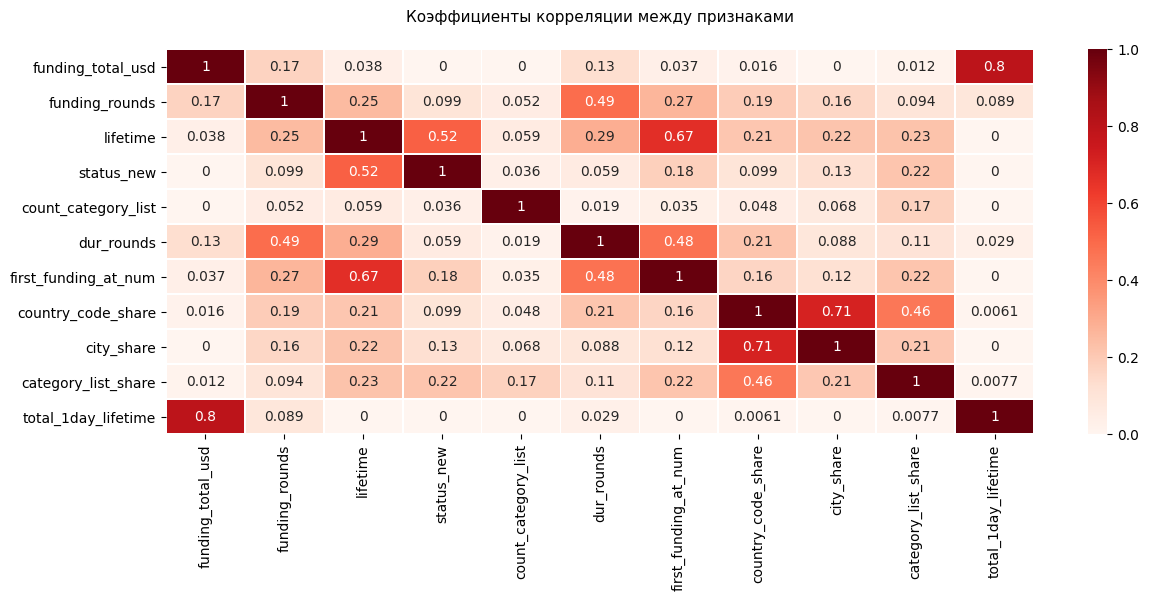

In [133]:
# задаем размер и четкость-количество точек на дюйм
plt.figure(dpi=100, figsize=(14,5))
# Заголовок
plt.title('Коэффициенты корреляции между признаками', y=1.05, fontsize=11);
# подпись по осям

interval_cols = df.select_dtypes(include='number').columns.tolist() # числовые столбцы

sns.heatmap(df.phik_matrix(interval_cols=interval_cols), linewidth=0.5, cmap='Reds', annot=True);

**`Посмотрим, какие признаки имеют наиболее сильную корреляцию с целевым - со статусом стартапа.`**    
**Показатели коррелированности по [шкале Чеддока](https://math.semestr.ru/corel/cheddok.php):**     
**Весьма высокая (0.9-1):**      
- нет.     
**Высокая корреляция (0.7-0.9):**       
- нет.     
**Заметная корреляция (0.5-0.7):**             
- между статусом стартапа и временем жизни стартапа (коэффициент корреляции 0.52).                  
**Умеренная корреляция (0.3-0.5):**               
- нет.    
**Слабая корреляция (0.1-0.3):**                  
- между статусом стартапа и долей категории деятельности (коэффициент корреляции 0.22).   
- между статусом стартапа и числовым значением первого дня финансирования проекта (коэффициент корреляции 0.18).    
- между статусом стартапа и долей города регистрации стартапа (коэффициент корреляции 0.13).   
**Практически отсутствует (0-0.1):**                  
- оставшиеся признаки.             

**Посмотрим, как связаны между собой входные признаки.**  
**Весьма высокая (0.9-1):**      
- нет.

**Мультиколлинеарность не обнаружена (линейная зависимость между входными признаками).**

## Моделирование продолжения деятельности стартапа

### Применение CatBoostClassifier без кросс-валидации и поиска по сетке

**Разобъем наш датафрейм df на 3 части: обучающую, валидационную и тестовую. Если нас устроит результат, то впоследствии мы обучим модель на всех данных.**

In [134]:
# разбиение с учетом дисбаланса классов
train, test = train_test_split(df,train_size=0.6,random_state=RANDOM_STATE,stratify=df['status_new'])
val, test = train_test_split(test,train_size=0.5,random_state=RANDOM_STATE,stratify=test['status_new'])

In [135]:
train.shape, val.shape, test.shape

((31504, 11), (10502, 11), (10502, 11))

In [136]:
df.drop(columns={'status_new'}).select_dtypes(include='number').columns.tolist()

['funding_total_usd',
 'funding_rounds',
 'lifetime',
 'count_category_list',
 'dur_rounds',
 'first_funding_at_num',
 'country_code_share',
 'city_share',
 'category_list_share',
 'total_1day_lifetime']

In [137]:
# список с признаками кроме целевого
X = ['funding_total_usd',
 'funding_rounds',
 'lifetime',
 'count_category_list',
 'dur_rounds', 
 'first_funding_at_num',
 'country_code_share',
 'city_share',
 'category_list_share',
 'total_1day_lifetime'
    ]
# целевой признак
y = ['status_new']

In [138]:
#создание пулов для тренировочных, валидац., тестов. данных
train_data = Pool(data=train[X],
                  label=train[y],
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                 )

test_data = Pool(data=test[X],
                  label=test[y],
                 )

In [139]:
# гиперпараметры для модели
params = {'verbose':100,
          'eval_metric':'F1',
          'loss_function': 'Logloss',
          'random_seed':RANDOM_STATE,
          'learning_rate':0.017
       # можно рассмотреть и др.гиперпараметры   
       #  'l2_leaf_reg':7,
       #   'od_type':"Iter",
       #   'od_wait':75,
        #'auto_class_weights':'Balanced',
         #   'depth':6
        }

In [140]:
model = CatBoostClassifier(**params)
model.fit(train_data, eval_set=valid_data)

0:	learn: 0.7352049	test: 0.7453833	best: 0.7453833 (0)	total: 154ms	remaining: 2m 33s
100:	learn: 0.8233243	test: 0.8298611	best: 0.8303416 (92)	total: 1.14s	remaining: 10.2s
200:	learn: 0.8513208	test: 0.8539326	best: 0.8539326 (198)	total: 2.19s	remaining: 8.69s
300:	learn: 0.8571429	test: 0.8592179	best: 0.8592179 (281)	total: 3.24s	remaining: 7.52s
400:	learn: 0.8642390	test: 0.8619154	best: 0.8628763 (367)	total: 4.21s	remaining: 6.29s
500:	learn: 0.8671016	test: 0.8655230	best: 0.8655230 (500)	total: 5.2s	remaining: 5.18s
600:	learn: 0.8716806	test: 0.8669244	best: 0.8675497 (593)	total: 6.24s	remaining: 4.14s
700:	learn: 0.8756016	test: 0.8687982	best: 0.8700441 (663)	total: 7.21s	remaining: 3.08s
800:	learn: 0.8798671	test: 0.8715697	best: 0.8720483 (786)	total: 8.17s	remaining: 2.03s
900:	learn: 0.8846012	test: 0.8763676	best: 0.8763676 (896)	total: 9.14s	remaining: 1s
999:	learn: 0.8880734	test: 0.8769820	best: 0.8774617 (914)	total: 10.1s	remaining: 0us

bestTest = 0.877461

**Получили на валидационной выборке метрику f1 = 0.87 на 915 итерации.**

In [141]:
n_iters = model.best_iteration_ + 1 

In [142]:
params = {
    'iterations':n_iters,
          'verbose':100,
          'eval_metric':'F1',
          'loss_function': 'Logloss',
          'random_seed':RANDOM_STATE,
          'learning_rate':0.017
       # можно рассмотреть и др.гиперпараметры   
       #  'l2_leaf_reg':7,
       #   'od_type':"Iter",
       #   'od_wait':75,
        #'auto_class_weights':'Balanced',
         #   'depth':6
        }

In [143]:
# с лучшим гиперпараметром iterations
model = CatBoostClassifier(**params)

In [144]:
# объединение обучающего и валидационного датафреймов для обучения на этих данных
train_full = pd.concat([train,val])

In [145]:
# создание пула, содержащего данные для обучения
train_full_data = Pool(train_full[X],
                       label=train_full[y]
                       )

In [146]:
# обучение на объединенных данных
model.fit(train_full_data, eval_set=test_data)

0:	learn: 0.7402387	test: 0.7393586	best: 0.7393586 (0)	total: 15.8ms	remaining: 14.5s
100:	learn: 0.8262001	test: 0.8378534	best: 0.8378534 (98)	total: 1.07s	remaining: 8.63s
200:	learn: 0.8520141	test: 0.8655037	best: 0.8655037 (196)	total: 2.12s	remaining: 7.53s
300:	learn: 0.8629811	test: 0.8775056	best: 0.8779944 (294)	total: 3.17s	remaining: 6.47s
400:	learn: 0.8671133	test: 0.8821251	best: 0.8826135 (376)	total: 4.22s	remaining: 5.41s
500:	learn: 0.8705817	test: 0.8823854	best: 0.8826135 (376)	total: 5.34s	remaining: 4.42s
600:	learn: 0.8745669	test: 0.8842337	best: 0.8848485 (591)	total: 6.44s	remaining: 3.37s
700:	learn: 0.8776103	test: 0.8869374	best: 0.8879121 (642)	total: 7.56s	remaining: 2.31s
800:	learn: 0.8808834	test: 0.8881579	best: 0.8886451 (776)	total: 8.7s	remaining: 1.24s
900:	learn: 0.8836569	test: 0.8875480	best: 0.8886451 (776)	total: 9.75s	remaining: 151ms
914:	learn: 0.8837209	test: 0.8875480	best: 0.8886451 (776)	total: 9.9s	remaining: 0us

bestTest = 0.8886

**Получили на тестовой выборке метрику f1 = 0.889 на 776 итерации.**

**Посмотрим на отчет по классификации.**

In [147]:
print(classification_report(test['status_new'],model.predict(test_data)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9519
           1       0.96      0.82      0.89       983

    accuracy                           0.98     10502
   macro avg       0.97      0.91      0.94     10502
weighted avg       0.98      0.98      0.98     10502



**Теперь, если нас результат устраивает, мы можем обучить модель на всей выборке. И посчитать f1.**

In [148]:
# объединяем все данные
train_full_full = pd.concat([train_full, test])

In [149]:
#формируем пул для обучения
train_full_full_data = Pool(train_full_full[X],
                       label=train_full_full[y]
                       )

In [150]:
params = {
    'iterations':777,
          'verbose':100,
          'eval_metric':'F1',
          'loss_function': 'Logloss',
          'random_seed':RANDOM_STATE,
          'learning_rate':0.017
}

In [151]:
# с лучшим гиперпараметром iterations
model = CatBoostClassifier(**params)
# обучение на всех данных
model.fit(train_full_full_data)

0:	learn: 0.7897249	total: 13.9ms	remaining: 10.8s
100:	learn: 0.8299052	total: 1.14s	remaining: 7.64s
200:	learn: 0.8558853	total: 2.26s	remaining: 6.47s
300:	learn: 0.8648830	total: 3.37s	remaining: 5.33s
400:	learn: 0.8705725	total: 4.5s	remaining: 4.21s
500:	learn: 0.8743072	total: 5.74s	remaining: 3.16s
600:	learn: 0.8790189	total: 6.87s	remaining: 2.01s
700:	learn: 0.8820739	total: 8.06s	remaining: 873ms
776:	learn: 0.8844077	total: 8.95s	remaining: 0us


**Получили f1 на всех данных 0.88.**

**То есть мы можем предполагать, так как в тестовой выборке kaggle_test_number распределение данных не сильно отличается от обучающей, то метрика f1 ожидается примерно рядом с 0.88.** 

**Возникает вопрос: как улучшить еще метрику?**    
Возможные варианты: 
* подбор гиперпараметров с кросс-валидацией,   
* генерирование новых синтетических столбцов,  
* подбор порога для скоров,    
* вариант взвешивания классов вручную через ADASYN (помогает обучиться на границе разделения классов) либо SMOTETomek (одновременно oversampling и undersampling),  
* другая модель, например, SVC, RandomForestClassifier.
* возможно, заполнить пропуски другим образом.
* попробовать произвести оптимизацию через Optuna.
* изменить признаковое пространство, например, удалить неважные признаки,
* изменить объекты в обучающей выборке, например, удалить часть строк, которые мешают процессу обучения, то есть их можно удалять, если структуры данных при этом станут более похожи.  

### CatBoostClassifier с RandomizedSearchCV

**Подберем гиперпараметры модели со случайным поиском по сетке.**

Чтобы узнать все возможные гиперпараметры, нееобходимо вызвать команду model.get_all_params().

In [152]:
#список числовых столбцов
df.drop(columns={'status_new'}).select_dtypes(include='number').columns.tolist()

['funding_total_usd',
 'funding_rounds',
 'lifetime',
 'count_category_list',
 'dur_rounds',
 'first_funding_at_num',
 'country_code_share',
 'city_share',
 'category_list_share',
 'total_1day_lifetime']

In [153]:
# список с признаками кроме целевого
X = ['funding_total_usd',
 'funding_rounds',
 'lifetime',
 'count_category_list',
 'dur_rounds', 
 'first_funding_at_num',
 'country_code_share',
 'city_share',
 'category_list_share',
 'total_1day_lifetime'
    ]
# целевой признак
y = ['status_new']

In [154]:
X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], stratify=df[y], test_size=0.1,random_state=42)

In [155]:
params = {       
# закомментировала часть гиперпараметров, можно раскомментировать и делать более широкий поиск гиперпараметров
#    'iterations': randint(1000, 2000),
    'learning_rate': [0.03, 0.04, 0.05]
#    'depth': randint(5, 10),
#    'learning_rate': uniform(0.02,0.06),
#    'l2_leaf_reg': randint(3, 10),
#   'border_count': randint(100, 300),
#    'bagging_temperature': uniform(0.2,0.81),
#    'od_wait'=[20, 30, 40, 50, 60, 70]
}
pp={
    #'iterations': 2000,
    'bagging_temperature': 0.4,
    'border_count': 232,
    'depth': 7,
    'l2_leaf_reg': 3,
    'random_seed':RANDOM_STATE,
    'loss_function':'Logloss', 
    'od_type':'Iter', 
   #   'od_wait':75,
   #'auto_class_weights':'Balanced',
     'verbose':False
   #'use_best_model':True
   }

model = CatBoostClassifier(**pp)

search = GridSearchCV(model, params, scoring='f1')
#search = RandomizedSearchCV(model, param_distributions=params, n_iter=3, scoring='f1')

# Обучение модели, поиск гиперпараметров
search.fit(X_train, y_train, eval_set=(X_test, y_test))

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x00000231EDA48550>,
             param_grid={'learning_rate': [0.03, 0.04, 0.05]}, scoring='f1')

In [156]:
search.best_params_ # лучшие гиперпараметры

{'learning_rate': 0.03}

In [157]:
predictions=search.predict(X_test)

In [158]:
predictions

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [159]:
search.best_estimator_ #лучшая модель

In [160]:
model=search.best_estimator_ #запоминаем лучшую модель

In [161]:
print(classification_report(y_test, predictions)) #отчет по классификации

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4759
           1       0.93      0.82      0.87       492

    accuracy                           0.98      5251
   macro avg       0.96      0.91      0.93      5251
weighted avg       0.98      0.98      0.98      5251



**Объединим обучающий и тестовый датасеты и обучим модель на оптимальных гиперпараметрах.**

In [162]:
n_iters = model.best_iteration_ + 1 

In [163]:
pp={
    'iterations': n_iters,
    'learning_rate': 0.03,   #найденнное оптим. значение
    'bagging_temperature': 0.4,
    'border_count': 232,
    'depth': 7,
    'l2_leaf_reg': 3,
    'random_seed':42,
    'loss_function':'Logloss', 
    'od_type':'Iter', 
   #   'od_wait':75,
   #'auto_class_weights':'Balanced',
  #   'verbose':False
  
   }

In [164]:
# объединение обучающего и тестового датафреймов для обучения на этих данных
full_X = pd.concat([X_train, X_test])
full_y = pd.concat([y_train, y_test])

In [165]:
model = CatBoostClassifier(**pp,eval_metric='F1', verbose=100)

In [166]:
# обучение на объединенных данных
model.fit(full_X, full_y)

0:	learn: 0.7831209	total: 17.6ms	remaining: 13.3s
100:	learn: 0.8576581	total: 1.81s	remaining: 11.8s
200:	learn: 0.8736245	total: 3.09s	remaining: 8.54s
300:	learn: 0.8822166	total: 4.43s	remaining: 6.72s
400:	learn: 0.8861010	total: 5.91s	remaining: 5.24s
500:	learn: 0.8906456	total: 7.22s	remaining: 3.69s
600:	learn: 0.8948232	total: 8.6s	remaining: 2.23s
700:	learn: 0.8989083	total: 10.4s	remaining: 830ms
756:	learn: 0.9006868	total: 11.2s	remaining: 0us


**Метрика f1=0.9 на обучающей выборке.**

**Сделаем прогноз на тестовой выборке kaggle_test.**

In [167]:
model.predict(kaggle_test_number)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [168]:
# добавляем столбец status в датасет kaggle_test_number
kaggle_test_number['status'] = model.predict(kaggle_test_number)
kaggle_test_number.head()

,funding_total_usd,funding_rounds,lifetime,count_category_list,dur_rounds,first_funding_at_num,country_code_share,city_share,category_list_share,total_1day_lifetime,status
name,,,,,,,,,,,
Crystalsol,2819200.0,1,3501,18,1,14426,0.000076,0.120914,0.017829,805.255641,0
ALUHEAT,2486835.0,1,3267,18,1,14848,0.105295,0.120914,0.017829,761.198347,0
Airsynergy,2573200.0,1,2034,18,1,16128,0.105295,0.120914,0.017829,1265.093412,0
Red Ambiental,20000000.0,1,2192,18,1,14054,0.105295,0.120914,0.017829,9124.087591,1
Wheego Electric Cars,5000000.0,2,4217,18,1220,13514,0.105295,0.120914,0.017829,1185.677022,0


**Посмотрим на образец того, как должен выглядеть столбец.**

In [169]:
df_sample = pd.read_csv('kaggle_startups_sample_submit_28062024.csv')
df_sample 

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,closed
13123,AdWill,operating


**Нам надо обеспечить тот же порядок следования строк, как и в образце `df_sample`. Поэтому будем использовать датасет `df_sample`, удалим из него столбец `status`, затем обединим `df_sample` с предсказаниями `kaggle_test_number[['status']]` по индексу `name`. в столбце `status` обеспечим возможные варианты ответов: 'operating', 'closed'.**

In [170]:
df_sample = df_sample.drop('status', axis=1)
df_sample = df_sample.reset_index()
df_sample = df_sample.set_index('name')
df_sample = df_sample.join(kaggle_test_number[['status']])
df_sample = df_sample.sort_values('index')
df_sample = df_sample.reset_index().drop('index', axis=1)
df_sample['status'] = df_sample['status'].map({0:'operating', 1:'closed'})
df_sample

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,operating


**Для записи в файл необходимо выпольнить команду: `df_sample.to_csv('catboost_predict.csv',index=False)`. Для просмотра текущей директории, кужда записался файл, необходимо выполнить команду `pwd`.**

In [171]:
# df_sample.to_csv('catboost_predict.csv',index=False)

## Анализ важности признаков

In [172]:
model.feature_importances_

array([ 3.44008105,  1.34920476, 40.5923454 ,  3.64222851,  3.75787065,
       29.05421056,  3.45336949,  5.23766865,  5.46657436,  4.00644657])

In [173]:
df_feature_importance = model.get_feature_importance(prettified=True)
df_feature_importance

,Feature Id,Importances
0,lifetime,40.592345
1,first_funding_at_num,29.054211
2,category_list_share,5.466574
3,city_share,5.237669
4,total_1day_lifetime,4.006447
5,dur_rounds,3.757871
6,count_category_list,3.642229
7,country_code_share,3.453369
8,funding_total_usd,3.440081
9,funding_rounds,1.349205


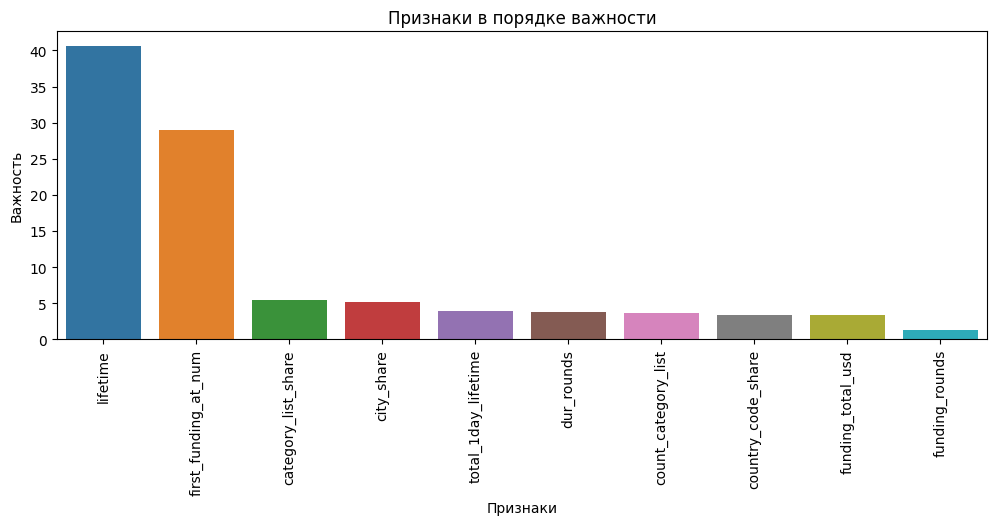

In [174]:
plt.figure(figsize=(12,4))
sns.barplot(data=df_feature_importance, x=df_feature_importance['Feature Id'], y=df_feature_importance['Importances'])
plt.xticks(rotation=90);
plt.title('Признаки в порядке важности');
plt.xlabel('Признаки');
plt.ylabel('Важность');

**Наиболее важные признаки: время существования стартапа, первая дата финансирования стартапа. Наименее важные признаки: количество раундов.**

Посмотрим на важность признаков с помощью shap.

100%|===================| 5230/5251 [03:20<00:00]        

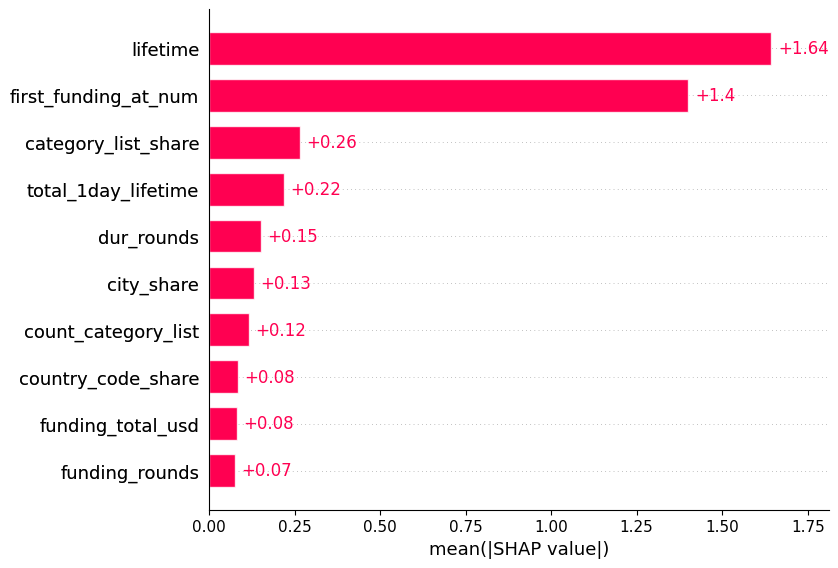

In [175]:
shap.initjs() # для красивой визуализации shap
# инициализация объекта
explainer = shap.TreeExplainer(model, X_test[X])
# вычисление значений Шепли для тестовой выборки
shap_values_test = explainer(X_test[X])
shap.plots.bar(shap_values_test)

Мы видим, что shap и catboost имеют отличия в оценке важности некоторых признаков, что связано с разными подходами к оценке. 

**Анализ модели с помощью Shap**

Однозначную оценку вклада признака в каждый прогноз показывают значения Шепли, их оценивают методом SHAP (SHapley Additive exPlanations). Он вычисляет, как отдельный признак помог присвоить модели итоговое значение целевого.

Значение Шепли изначально рассчитывают для каждого отдельного наблюдения в выборке. Для этого алгоритм SHAP анализирует все возможные комбинации признаков и выявляет вклад каждого из них в предсказания. Если вам нужно узнать вклад признака на всех данных, то SHAP может агрегировать индивидуальные значения Шепли: высчитает среднее модулей каждого из них или суммирует их по модулю.    
Значения Шепли требуют большой мощи компьютера, поэтому для их расчёта используют алгоритмы оптимизации вычислений. 

Посмотрим на график summary_plot, который показывает, куда каждый из признаков двигает финальный предикт: в сторону класса 0 или класса 1.

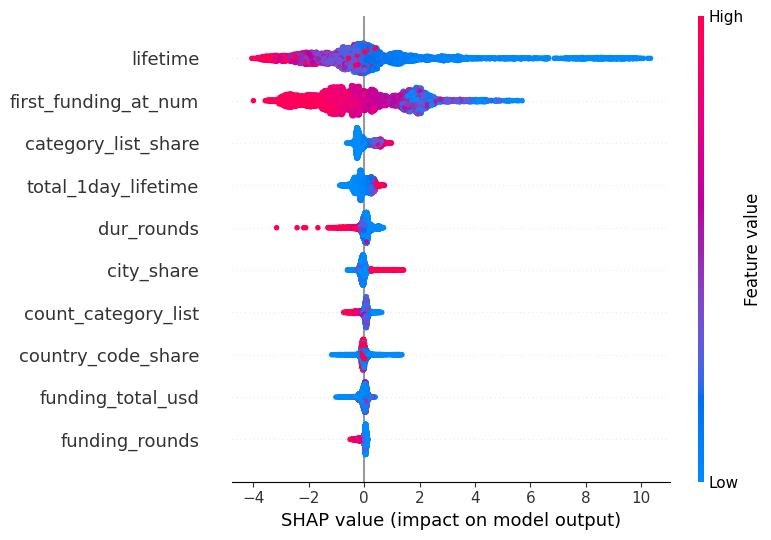

In [176]:
shap.summary_plot(shap_values_test, X_test)

Это один из вариантов визуализации вклада признаков в каждое предсказание модели. На графике точками отображены все наблюдения из выборки.
На оси 𝑋 отложены значения Шепли, на оси 𝑌 — признаки модели.

**Как читать этот график:**        
* Отрицательные значения Шепли означают, что признак склоняет модель отнести объекты к классу 0, а положительные значения - к классу 1.
* Чем больше высота линии, тем больше наблюдений сгруппированы вместе: у них близкие значения Шепли. Это значит, что модель уверенно присваивает SHAP-значения с учетом закономерностей в данных.
* Цвет точки отображает значения каждого признака объекта. Красному цвету соответствуют большие значения признака, синему - меньшие. 

На графике видно, что чем больше время существования стартапа (красным цветом выделены высокие значения), тем больше модель склоняет отнести объект к классу 0 (отрицательные значения Шепли означают, что признак склонен отнести объект к классу 0). И наоборот.  
Для числового значения первой даты финансирования модель также склоняет отнести объект к классу 0 при высоких значениях признака даты, так как им соответствуют отрицательные значения Шепли. И при более низких значениях к классу 1.    
Признак с долей категории деятельности: более высокие значения признака склоняют модель отнести объект к классу 1. Это объясняется тем, что популярным категориям соответствует большее количество стартапов. Соответственно среди них часть закрывается.  Тоже самое можно сказать про признак с долей города: высокие значения увеличивают вероятность принадлежности к классу 1. Наверное, это связано с тем, что в крупных городах большее количество стартапов, часть из них закрывается.    
Большие значения суммы финансирования на 1 день жизни проекта склоняют модель отнести объект к классу 1 (закроется). Это связано с тем, что сумма на 1 день жизни проекта обратно пропорциональна времени жизни проекта.   
Большие значения количества категорий деятельности (count_category_list) склоняют объект отнести к классу 0. Наверное, это связано с тем, что стартап можно применить ко многим сферам жизнедеятельности.    
Большие значения продолжительности между первой и последней датой финансировансирования двигают предикт в сторону 0 класса.
По поводу суммы финансирования стартапа: малые значения признака характерны и для класса 0, и для класса 1. Этот признак не несет пользы. Его можно исключить, тем более что информация из него присутствует в признаке сумма финансирования на 1 день жизни стартапа.   
Большие значения количества раундов двигают предикт в сторону 0 класса.

## Вывод

**По техническому заданию требуется разработать модель, которая проклассифицирует стартапы (не закроется / закроется).**   

* В основных данных приводится информация о стартапах: сумма финансирования, первая и последняя даты финансирования, даты открытия и закрытия стартапа (а для тестового датасета вместо этих признаков время жизни стартапа), территориальное расположение (регион, штат, страна, город), категория деятельности стартапа, название (уникальное).   
Информация представлена в 3 датасетах. Один - обучающий, второй - тестовый, третий содержит образец ответа.  
* Исходные данные содержат пропуски по категориальным признакам (категория деятельности, страна, регион, город, штат) и по сумме финансирования. Также есть пропуск названия одного стартапа в обучающем датасете. Для категориальных переменных пропуски обработаны заглушкой "Unknown". Пропуски по сумме финансирования заполнены медианным значением в соответствии с категорией деятельности и страной принадлежности. В случае оставшихся пропусков они заполнены медианным значением по сумме финансирования.
* Исходные данные не содержат дубликатов. Столбцы с датами преобразованы к типу datetime. Удалено 8 строк (стартапов) в обучающем датасете, что увеличило схожесть структуры данных тренировочного и тестового датасетов. Добавлен в обучащий датасет столбец со сроком существования стартапа.  Данные в датасетах приведены к одинаковому признаковому пространству.
* Исследовательский анализ данных показал, что определяющим признаком классификации стартапов является продолжительность существования стартапа.
Также было замечено, что распределение данных в обучающем и тестовом датасетах очень схож. Сумма финансирования стартапа не дает однозначного ответа, так как и большие, и малые суммы финансирования соответствуют и открытым, и закрытым стартапам. Поэтому этот признак можно рассматривать в связке с каким-нибудь другим либо другими, создав синтетический признак, как сделано в проекте (сумма финансирования на 1 день жизни стартапа).  Категорий в категориальных колонках очень много, что говорит о том, что желательно их каким-либо образом уменьшить либо перейти от категориальных признаков к числовым. В связи с этим, возникает необходимость создания новых синтетических столбцов на основе существующих.
* Добавлены синтетические столбцы:  продолжительность раундов (по аналогии с lifetime), числовое представление первой даты финансирования стартапа (как количество дней с 1 января 1970 года), количество категорий в колонке с категорией деятельности, столбцы с долей каждой страны, каждого города, каждой категории в данных. Таким образом, сделан переход от категориальных колонок к числовым. Оставлены только числовые колонки.
* Корреляционный анализ показал, что заметная связь между статусом проекта и временем жизни проекта. Слабая корреляция между статусом проекта и долей категории, долей города, первой датой финансирования (в числовом варианте). Практически отсутствует связь между статусом проекта и остальными признаками. Мультиколлинеарность между входными признаками не обнаружена.
* При моделировании продолжительности деятельности стартапа использовался CatBoostClassifier. В классах имеется дисбаланс, поэтому в качестве метрики взята f1, так как эта метрика учитывает дисбаланс классов (является средним гармоническим между precision и recall, то есть ближе к меньшему из них).
* Анализ важности признаков с помощью shap показал, что наиболее сильное влияние на предсказание модели оказывает продолжительность существования стартапа (это ключевой признак). Поэтому при финансировании в стартапы надо, в первую очередь, обращать внимание на него. Наименее важные признаки (количество раундов, сумма финансирования, доля страны) можно исключить, тем более что информация по сумме финансирования передана в признак сумма финансирования на 1 день жизни стартапа. 
* На основе модели сделан прогноз деятельности стартапов. Результат отражен на площадке kaggle: текщее место 3, [результат на kaggle 0.89429](https://www.kaggle.com/competitions/startups-operations-close-predictions-m-1-39-ds/leaderboard)е

**PS:** Пробовала лог регрессию как некий baseline для старта (0.75-0.78), затем случайный лес (f1=0.87), SVC (0.84). Пробовала улучшить с Optuna (не помогло), также использовала GridSearch (не помогло), экспериментировала с порогом -  улучшают метрику. Ориентируясь на shap, куда какие признаки двигают предикт, ставила эксперименты с новыми синтетическими признаками, также в разрезе shap взглянула на некоторые ошибки FN - что сместило предикт в сторону ложного нуля. Пришла к выводу: какая-то часть строк мешает модели обучаться, их бы устранить, также надо бы еще добавить синтетики  (например, когорты), использовать пороги, тогда может быть смогла бы сдвинуться с 3 места вперед **:-)**
**PS:** У меня запуск этой тетрадки занимает 406 секунд. В первой ячейке прописаны все необходимые библиотеки. Если они не установлены, надо раскомментировать команды для их установки. Для запуска файла необходимы все 3 файла: kaggle_startups_train_28062024.csv, kaggle_startups_test_28062024.csv, kaggle_startups_test_28062024.csv. Нам Федор сказал, что прописывать свой домашний путь доступа к файлам, что, если надо запустить, у ревьюера все файлы есть.